# Projektowa Praca Domowa z Programowania Dla Analityki Danych

Wykonał Michał Brodacki, s32038

Wykorzystano następujące biblioteki:

In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
import statsmodels.formula.api as smf

import plotly.graph_objects as go

Zacznijmy od wczytania danych i zobaczenia jak wyglądają

In [2]:
df = pd.read_csv("messy_data.csv")
df.head()

,carat,clarity,color,cut,x dimension,y dimension,z dimension,depth,table,price
0,0.5,IF,D,Ideal,5.1,5.15,3.2,61.5,,3000
1,0.7,vvs2,E,premium,5.7,,3.52,62,59,4500
2,NaN,Si2,h,Good,4.3,4.31,,62.3,56,700
3,1.2,if,d,ideal,,6.82,4.2,61.7,58,10000
4,0.9,I1,J,Fair,6,,3.7,61.7,,2400


## Wstępna Analiza Danych
Spróbujmy opisać zmienne:
- carat - wartość liczbowa reprezentująca karaty, czyli ?
- clarity - Zmienna kategoryczna
- Color - również zmienna kategoryczna, widzimy duże i małe litery, pytanie czy to błąd kodowania czy tak specjalnie
- cut - zmienna kategoryczna, sugeruje że badamy jakość cięcia, tutaj mamy pewność że kodowanie jest błędne
- x,y,z dimension - jakieś wymiary, sporo brakujących wartości
- depth - wartość numeryczna
- table - rónież wartość numeryczna, która jednak może sugerować jakiś porządek
- price - to pewnie cena

Szybki research w internecie (jako iż data scientist powinien mieć trochę wiedzy dziedzinowej):
- Karat jest jednostką masy używaną w jubilerstwie do określania masy kamieni (pierwsze wyszukanie w google), reszte zmiennych można doprecyzować dzięki temu
- clarity - to pewnie zmienna kategoryczna mówiąca nam o materiale z jakiego wykonano kamieć 
- color - to po prostu kolor kamienia
- cut - to sposób jego cięcia
- x,y,z dimensions - wymiary kamienia
- depth - co to jest depth kamienia? To także wyszukałem w google "depth of diamond" z takim rezultatem:
depth is deemed acceptable within a certain range, with any value between 56.5 and 65 percent considered good.

Ponieważ jest to jakiś procent, tyczący się rozmiaru, poszukałem na niego wzór i dostałem coś takiego:
$$ depth = \frac{z}{\frac{1}{2}(x+y)} $$
Za pomocą tego wzoru możemy uzupełnić brakujące wartości dla x,y,z dimensions oraz depth. Podsumowując:
- depth - Procent, określający zależność między wymiarami (będzie trzeba pominąć przy modelowaniu, bo jest silnie skorelowany z wymiarami.)
z analogicznego rozumowania
- table - też jakaś proporcja wyrażana procentowo
- price - w dalszym ciągu cena

Gdy już wiem, jak podejść do danych, przejdźmy do czyszczenia:

## Czyszczenia
Zmienię trochę kolejnośc wykonywania działań w stosunku do tej w poleceniu zaczynając od spójności, gdyż spacje w nazwach kolumn, oraz źle zakodowane wartości utrudniają pozostałe kroki. Potem zajmiemy się brakującymi wartościami, za pomocą wzorów i nie tylko

### c) Spójność i f) Inne 
- Zacznijmy od usunięcia spacji przed i po nazwie kolumny (ułatwi to pisanie kodu i nie tylko)

In [3]:
df.columns
df.columns = df.columns.str.strip()
df.head()

,carat,clarity,color,cut,x dimension,y dimension,z dimension,depth,table,price
0,0.5,IF,D,Ideal,5.1,5.15,3.2,61.5,,3000
1,0.7,vvs2,E,premium,5.7,,3.52,62,59,4500
2,NaN,Si2,h,Good,4.3,4.31,,62.3,56,700
3,1.2,if,d,ideal,,6.82,4.2,61.7,58,10000
4,0.9,I1,J,Fair,6,,3.7,61.7,,2400


- Zakodujmy nazwy ze spacją w środku jako podłogą

In [4]:
df.rename(columns={'x dimension': "x_dim"}, inplace=True)
df.rename(columns={'y dimension': "y_dim"}, inplace=True)
df.rename(columns={'z dimension': "z_dim"}, inplace=True)
df.head()

,carat,clarity,color,cut,x_dim,y_dim,z_dim,depth,table,price
0,0.5,IF,D,Ideal,5.1,5.15,3.2,61.5,,3000
1,0.7,vvs2,E,premium,5.7,,3.52,62,59,4500
2,NaN,Si2,h,Good,4.3,4.31,,62.3,56,700
3,1.2,if,d,ideal,,6.82,4.2,61.7,58,10000
4,0.9,I1,J,Fair,6,,3.7,61.7,,2400


Skoro rozwiązaliśmy już problem z nagłówkami, to przejdźmy teraz do sprawdzenia typów w każdej kolumnie, oraz kodowania wartości:

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    150 non-null    float64
 1   clarity  200 non-null    object 
 2   color    200 non-null    object 
 3   cut      200 non-null    object 
 4   x_dim    200 non-null    object 
 5   y_dim    200 non-null    object 
 6   z_dim    200 non-null    object 
 7   depth    200 non-null    object 
 8   table    200 non-null    object 
 9   price    200 non-null    object 
dtypes: float64(1), object(9)
memory usage: 15.8+ KB


Mimo widocznych w headerze pustych wartości nie są one klasyfikowane jako 'Null', dodam że przez to nie działało mi np. sprawdzanie wartości odstających dla zmiennych liczbowych. Dlatego dobrze, że znaleziony został korzeń problemu.

Ostatecznie wystarczy wczytać dane z separatorem zawierającym spację po przecinku, co zaobserwowałem dopiero po prześledzeniu udostępnionego pliku.

In [6]:
df = pd.read_csv('messy_data.csv', sep=', ')
df.rename(columns={'x dimension': "x_dim"}, inplace=True)
df.rename(columns={'y dimension': "y_dim"}, inplace=True)
df.rename(columns={'z dimension': "z_dim"}, inplace=True)
df.head()

C:\Users\micha\AppData\Local\Temp\ipykernel_15544\619100620.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv('messy_data.csv', sep=', ')


,carat,clarity,color,cut,x_dim,y_dim,z_dim,depth,table,price
0,0.5,IF,D,Ideal,5.1,5.15,3.20,61.5,NaN,3000.0
1,0.7,vvs2,E,premium,5.7,NaN,3.52,62.0,59,4500.0
2,NaN,Si2,h,Good,4.3,4.31,NaN,62.3,56,700.0
3,1.2,if,d,ideal,NaN,6.82,4.20,61.7,58,10000.0
4,0.9,I1,J,Fair,6.0,NaN,3.70,61.7,NaN,2400.0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    150 non-null    float64
 1   clarity  200 non-null    object 
 2   color    200 non-null    object 
 3   cut      200 non-null    object 
 4   x_dim    197 non-null    float64
 5   y_dim    136 non-null    float64
 6   z_dim    152 non-null    float64
 7   depth    133 non-null    float64
 8   table    168 non-null    object 
 9   price    196 non-null    float64
dtypes: float64(6), object(4)
memory usage: 15.8+ KB


Widzimy, że dla wielu kolumn typ się już zgadza, jednak dla kolumny 'table' dalej jest coś nie tak, spójrzmy:

In [8]:
df.table.unique()

array([nan, '59', '56', '58', '57', ',', '58,', '54', '57,', '60', '55'],
      dtype=object)

Problemem są dwie wartości z ',' oraz '57,'

In [9]:
df.table.replace(',', np.nan, inplace=True)
df.table.replace('58,', 58, inplace=True)
df.table.replace('57,', 57, inplace=True)
df.table.unique()

df.table = df.table.astype(float)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    150 non-null    float64
 1   clarity  200 non-null    object 
 2   color    200 non-null    object 
 3   cut      200 non-null    object 
 4   x_dim    197 non-null    float64
 5   y_dim    136 non-null    float64
 6   z_dim    152 non-null    float64
 7   depth    133 non-null    float64
 8   table    167 non-null    float64
 9   price    196 non-null    float64
dtypes: float64(7), object(3)
memory usage: 15.8+ KB


Dla kolumn numerycznych mamy załatwioną spójność, przygotowane jest do późniejszych działań (następnie podziałamy z wartościami brakującymi), zobaczmy jeszcze zmienne, które przyporządkujemy jako kategoryczne:

In [10]:
print("kolumna color przed działaniami: ", df.color.unique(),
" \n kolumna cut przed działaniami: ",df.cut.unique(),
" \n kolumna clarity przed działaniami: ", df.clarity.unique())

#Zakodujmy jednoznacznie jako string i z samymi wielkimi literami:
df.color = df.color.astype(str).str.upper()
df.cut = df.cut.astype(str).str.upper()
df.clarity = df.clarity.astype(str).str.upper()

print("kolumna color po działaniach: ", df.color.unique(),
" \n kolumna cut po działaniach: ",df.cut.unique(),
" \n kolumna clarity po działaniach: ", df.clarity.unique(),
" \n Oraz informacje o df po transformacjach: ")
df.info()

kolumna color przed działaniami:  ['D' 'E' 'h' 'd' 'J' 'G' 'f' 'I' 'F' 'Colorless' 'j' 'e' 'H' 'g'
 'colorless']  
 kolumna cut przed działaniami:  ['Ideal' 'premium' 'Good' 'ideal' 'Fair' 'very Good' 'good' 'Very good'
 'very good' 'fair' 'Premium' 'Very Good']  
 kolumna clarity przed działaniami:  ['IF' 'vvs2' 'Si2' 'if' 'I1' 'Si1' 'Vvs1' 'SI2' 'vvs1' 'si2' 'si1' 'i1'
 'VVS1' 'VVS2']
kolumna color po działaniach:  ['D' 'E' 'H' 'J' 'G' 'F' 'I' 'COLORLESS']  
 kolumna cut po działaniach:  ['IDEAL' 'PREMIUM' 'GOOD' 'FAIR' 'VERY GOOD']  
 kolumna clarity po działaniach:  ['IF' 'VVS2' 'SI2' 'I1' 'SI1' 'VVS1']  
 Oraz informacje o df po transformacjach: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    150 non-null    float64
 1   clarity  200 non-null    object 
 2   color    200 non-null    object 
 3   cut      200 non-null    object 
 4   x_

Typy się zgadzają, oraz kodowanie wygląda sensownie. Natępnym krokiem który podjąłbym, jest poradzenie sobie z brakującymi wartościami

### d) Braki w Danych
Powyżej doszukałem się wzoru na depth zależnego od x,y,z, wykorzystajmy go do predykcji

In [11]:
#Oddzielę w kopii na chwilę gdzie zmienna depth ma wartości NAN a xyz nie mają
df_copy = df[df['depth'].isna() & ~df[['x_dim', 'y_dim', 'z_dim']].isna().any(axis=1)]
df_copy['depth'] = (2*df_copy.z_dim/(df_copy.y_dim + df_copy.x_dim))*100 # razy 100 żeby skala byłą jak w głównych danych
print(df.depth.max(), df.depth.min())
print("Czy nowopowstałe wartości mieszczą się w przedziałach dla starych wartości: ",df_copy.depth.max() <= df.depth.max() and df_copy.depth.min() >= df.depth.min())
#print(df_copy)
df.loc[df_copy.index] = df_copy # powrót do starego df
# Analog dla x,y,z 
#z
df_copy = df[df['z_dim'].isna() & ~df[['x_dim', 'y_dim', 'depth']].isna().any(axis=1)]
df_copy['z_dim'] = (df_copy.depth*(df_copy.x_dim + df_copy.y_dim))/200 # razy 100 żeby skala byłą jak w głównych danych
print(df.z_dim.max(), df.z_dim.min())
print("Czy nowopowstałe wartości z dimension mieszczą się w przedziałach dla starych wartości: ",df_copy.z_dim.max() <= df.z_dim.max() + 0.01 and df_copy.z_dim.min() >= df.z_dim.min()) #Te zero zero jeden jest tak mało znaczące, że akceptujemy wyniki
#print(df_copy)
df.loc[df_copy.index] = df_copy # powrót do starego df
#x
df_copy = df[df['x_dim'].isna() & ~df[['z_dim', 'y_dim', 'depth']].isna().any(axis=1)]
df_copy['x_dim'] = ((df_copy.z_dim*200)/df_copy.depth) - df_copy.y_dim# razy 100 żeby skala byłą jak w głównych danych
print(df.x_dim.max(), df.x_dim.min())
print("Czy nowopowstałe wartości x dimension mieszczą się w przedziałach dla starych wartości: ",df_copy.x_dim.max() <= df.x_dim.max() and df_copy.x_dim.min() >= df.x_dim.min()) #Te zero zero jeden jest tak mało znaczące, że akceptujemy wyniki
#print(df_copy)
df.loc[df_copy.index] = df_copy # powrót do starego df
#y
df_copy = df[df['y_dim'].isna() & ~df[['z_dim', 'x_dim', 'depth']].isna().any(axis=1)]
df_copy['y_dim'] = ((df_copy.z_dim*200)/df_copy.depth) - df_copy.x_dim# razy 100 żeby skala byłą jak w głównych danych
print(df.y_dim.max(), df.y_dim.min())
print("Czy nowopowstałe wartości y dimension mieszczą się w przedziałach dla starych wartości: ",df_copy.y_dim.max() <= df.y_dim.max() and df_copy.y_dim.min() >= df.y_dim.min()) #Te zero zero jeden jest tak mało znaczące, że akceptujemy wyniki
#print(df_copy)
df.loc[df_copy.index] = df_copy # powrót do starego df

63.0 61.2
Czy nowopowstałe wartości mieszczą się w przedziałach dla starych wartości:  True


C:\Users\micha\AppData\Local\Temp\ipykernel_15544\336211791.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_copy['depth'] = (2*df_copy.z_dim/(df_copy.y_dim + df_copy.x_dim))*100 # razy 100 żeby skala byłą jak w głównych danych
C:\Users\micha\AppData\Local\Temp\ipykernel_15544\336211791.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_copy['z_dim'] = (df_copy.depth*(df_copy.x_dim + df_copy.y_dim))/200 # razy 100 żeby skala byłą jak w głównych danych
C:\Users\micha\AppData\Local\Temp\ipykernel_1

4.5 2.41
Czy nowopowstałe wartości z dimension mieszczą się w przedziałach dla starych wartości:  True
7.3 3.9
Czy nowopowstałe wartości x dimension mieszczą się w przedziałach dla starych wartości:  True
7.28 3.89
Czy nowopowstałe wartości y dimension mieszczą się w przedziałach dla starych wartości:  True


C:\Users\micha\AppData\Local\Temp\ipykernel_15544\336211791.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_copy['y_dim'] = ((df_copy.z_dim*200)/df_copy.depth) - df_copy.x_dim# razy 100 żeby skala byłą jak w głównych danych


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    150 non-null    float64
 1   clarity  200 non-null    object 
 2   color    200 non-null    object 
 3   cut      200 non-null    object 
 4   x_dim    200 non-null    float64
 5   y_dim    187 non-null    float64
 6   z_dim    195 non-null    float64
 7   depth    182 non-null    float64
 8   table    167 non-null    float64
 9   price    196 non-null    float64
dtypes: float64(7), object(3)
memory usage: 15.8+ KB


Dla Karatu,table nie mam clue, ani wzoru, więc spójrzmy na rozkład zmiennej. Natomiast dla price, jako iż będziemy je estymować, to te 4 NA nam mogą tylko zaburzyć model, więc usuniemy je

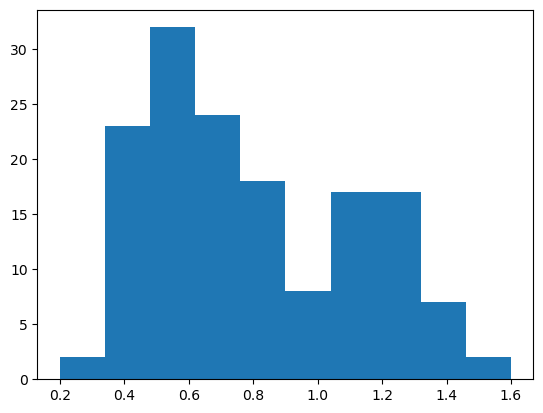

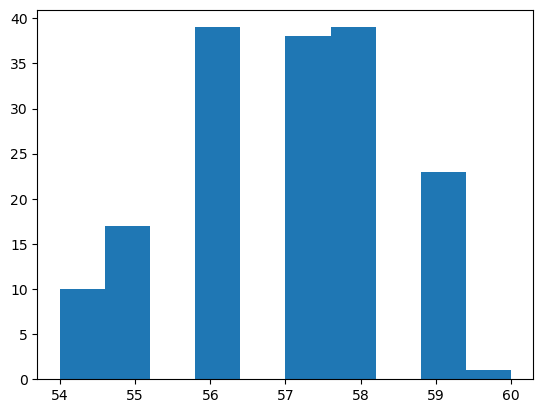

In [13]:
plt.hist(df.carat)
plt.show()
# z histogramu widać rozkład, zastąpmy NA po prostu medianą
df['carat'].fillna(df.carat.median(), inplace=True)
# dla table 
plt.hist(df.table)
plt.show()

df['table'].fillna(df.table.median(), inplace=True)

#Usuwamy NA w price
df = df.dropna(subset=['price'])


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 196 entries, 0 to 199
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    196 non-null    float64
 1   clarity  196 non-null    object 
 2   color    196 non-null    object 
 3   cut      196 non-null    object 
 4   x_dim    196 non-null    float64
 5   y_dim    183 non-null    float64
 6   z_dim    191 non-null    float64
 7   depth    178 non-null    float64
 8   table    196 non-null    float64
 9   price    196 non-null    float64
dtypes: float64(7), object(3)
memory usage: 16.8+ KB


Jeśli miałbym więcej obserwacji, to w takim momencie najpewniej usunąłbym te co nie przeszły poprzednich kroków, ale ponieważ jest ich mało, to wykorzystajmy średnią dla y_dim i z_dim, natomiast depth wyliczmy jeszcze raz ze wzoru:

In [15]:
#Pierwsze podejscie
df_test_yz_mean = df.copy()

df_test_yz_mean['z_dim'].fillna(df_test_yz_mean.z_dim.mean(), inplace=True)
df_test_yz_mean['y_dim'].fillna(df_test_yz_mean.y_dim.mean(), inplace=True)

df_copy = df_test_yz_mean[df_test_yz_mean['depth'].isna() & ~df_test_yz_mean[['x_dim', 'y_dim', 'z_dim']].isna().any(axis=1)]
df_copy['depth'] = (2*df_copy.z_dim/(df_copy.y_dim + df_copy.x_dim))*100 # razy 100 żeby skala byłą jak w głównych danych
print(df.depth.max(), df.depth.min())
print(df_copy.depth.max(), df_copy.depth.min())
print("Czy nowopowstałe wartości depth mieszczą się w przedziałach dla starych wartości: ",df_copy.depth.max() <= df.depth.max() and df_copy.depth.min() >= df.depth.min())

df_test_yz_mean.loc[df_copy.index] = df_copy # powrót do starego df

#Drugie podejscie
df_test_depth_mean = df.copy()
df_test_depth_mean['depth'].fillna(df_test_depth_mean.depth.mean(), inplace=True)
#z
df_copy = df_test_depth_mean[df_test_depth_mean['z_dim'].isna() & ~df_test_depth_mean[['x_dim', 'y_dim', 'depth']].isna().any(axis=1)]
df_copy['z_dim'] = (df_copy.depth*(df_copy.x_dim + df_copy.y_dim))/200 # razy 100 żeby skala byłą jak w głównych danych
print("Czy nowopowstałe wartości z dimension mieszczą się w przedziałach dla starych wartości: ",df_copy.z_dim.max() <= df.z_dim.max() + 0.01 and df_copy.z_dim.min() >= df.z_dim.min()) #Te zero zero jeden jest tak mało znaczące, że akceptujemy wyniki

df_test_depth_mean.loc[df_copy.index] = df_copy # powrót do starego df
#y
df_copy = df_test_depth_mean[df_test_depth_mean['y_dim'].isna() & ~df_test_depth_mean[['z_dim', 'x_dim', 'depth']].isna().any(axis=1)]
df_copy['y_dim'] = ((df_copy.z_dim*200)/df_copy.depth) - df_copy.x_dim# razy 100 żeby skala byłą jak w głównych danych
print("Czy nowopowstałe wartości y dimension mieszczą się w przedziałach dla starych wartości: ",df_copy.y_dim.max() <= df.y_dim.max() and df_copy.y_dim.min() >= df.y_dim.min()) #Te zero zero jeden jest tak mało znaczące, że akceptujemy wyniki

df_test_depth_mean.loc[df_copy.index] = df_copy # powrót do starego df

df_test_delete = df.dropna().copy()

63.0 61.2
70.37602425862468 57.929335561142395
Czy nowopowstałe wartości depth mieszczą się w przedziałach dla starych wartości:  False
Czy nowopowstałe wartości z dimension mieszczą się w przedziałach dla starych wartości:  True
Czy nowopowstałe wartości y dimension mieszczą się w przedziałach dla starych wartości:  True


C:\Users\micha\AppData\Local\Temp\ipykernel_15544\1570786122.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_copy['depth'] = (2*df_copy.z_dim/(df_copy.y_dim + df_copy.x_dim))*100 # razy 100 żeby skala byłą jak w głównych danych
C:\Users\micha\AppData\Local\Temp\ipykernel_15544\1570786122.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_copy['z_dim'] = (df_copy.depth*(df_copy.x_dim + df_copy.y_dim))/200 # razy 100 żeby skala byłą jak w głównych danych
C:\Users\micha\AppData\Local\Temp\ipykernel

Widzimy, że nowym wartościom dodanym przez średnią y,z jest coś nie halo w depth, sprawdzmy wykres wartości odstających bez tych danych, z danymi dodanymi za pomocą średniej y,z oraz za pomocą depth

In [16]:
#Dla sprawedzenia czy kopia działa poprawnie
df_test_delete.info()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 178 entries, 0 to 199
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    178 non-null    float64
 1   clarity  178 non-null    object 
 2   color    178 non-null    object 
 3   cut      178 non-null    object 
 4   x_dim    178 non-null    float64
 5   y_dim    178 non-null    float64
 6   z_dim    178 non-null    float64
 7   depth    178 non-null    float64
 8   table    178 non-null    float64
 9   price    178 non-null    float64
dtypes: float64(7), object(3)
memory usage: 15.3+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 196 entries, 0 to 199
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    196 non-null    float64
 1   clarity  196 non-null    object 
 2   color    196 non-null    object 
 3   cut      196 non-null    object 
 4   x_dim    196 non-null    float64
 5   y_dim    183 non-nul

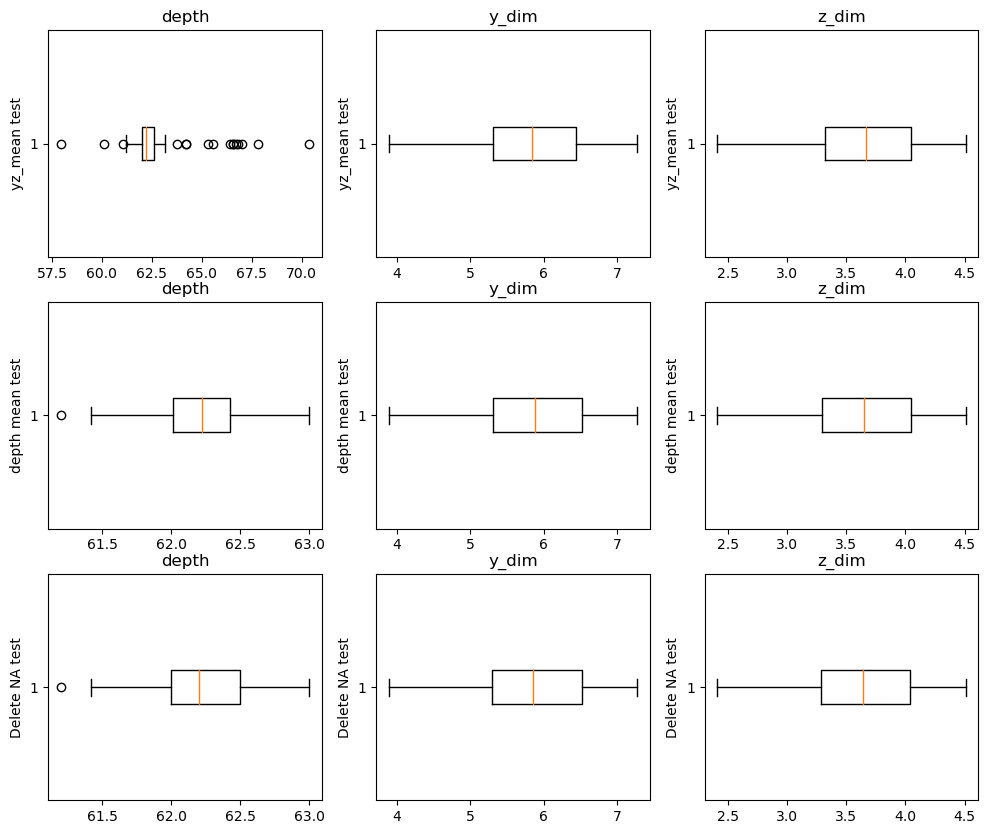

In [17]:
# Rysowanie boxplot z pominięciem brakujących wartości
data_to_plot = [df_test_yz_mean.depth, df_test_yz_mean.y_dim, df_test_yz_mean.z_dim,df_test_depth_mean.depth, df_test_depth_mean.y_dim, df_test_depth_mean.z_dim, df_test_delete.depth, df_test_delete.y_dim, df_test_delete.z_dim]

# Create a 3x3 grid of subplots
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 10))

# Flatten the axes array to easily access each subplot
axes = axes.flatten()

# Plot boxplots for each column in the DataFrame
for i, data in enumerate(data_to_plot):
    ax = axes[i]
    if i>= 0 and i<3:
        ax.set_ylabel("yz_mean test")
    elif i>= 3 and i<6:
        ax.set_ylabel("depth mean test")
    else: 
        ax.set_ylabel("Delete NA test")
    ax.set_title(data.name)
    ax.boxplot(data, vert=False)  # Drop NaN values for the boxplot


Z powyższych możemy wyciągnąć że dodanie wartości odstających za pomocą średniej z depth jest najrozsądniejsze bo nie kreuje dodatkowych wartości odstających, ani znacząco nie zmienia kwartyli widocznych w boxplocie w porównaniu do usunięcia wartości zawierających NA, więc z tą wiedzą dodajmy to do głównego dataframe'u i kontynuujmy.

In [18]:
df = df_test_depth_mean
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 196 entries, 0 to 199
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    196 non-null    float64
 1   clarity  196 non-null    object 
 2   color    196 non-null    object 
 3   cut      196 non-null    object 
 4   x_dim    196 non-null    float64
 5   y_dim    196 non-null    float64
 6   z_dim    196 non-null    float64
 7   depth    196 non-null    float64
 8   table    196 non-null    float64
 9   price    196 non-null    float64
dtypes: float64(7), object(3)
memory usage: 20.9+ KB


In [19]:
df.head()

,carat,clarity,color,cut,x_dim,y_dim,z_dim,depth,table,price
0,0.50,IF,D,IDEAL,5.100000,5.150000,3.200000,61.5,57.0,3000.0
1,0.70,VVS2,E,PREMIUM,5.700000,5.654839,3.520000,62.0,59.0,4500.0
2,0.75,SI2,H,GOOD,4.300000,4.310000,2.682015,62.3,56.0,700.0
3,1.20,IF,D,IDEAL,6.794263,6.820000,4.200000,61.7,58.0,10000.0
4,0.90,I1,J,FAIR,6.000000,5.993517,3.700000,61.7,57.0,2400.0


### a) Duplikaty
Po uzupełnieniu braków w danych możemy zobaczyć czy pojawiły się jakieś duplikaty


In [20]:
duplicates = df.duplicated()
print("Duplicates:")
print(df[duplicates])

Duplicates:
Empty DataFrame
Columns: [carat, clarity, color, cut, x_dim, y_dim, z_dim, depth, table, price]
Index: []


Nie mamy dwóch takich samych wierszy, a jedna inna wartość atrybutu zmienia, to już zupełnie inny kamień, czyli w tym przypadku, nie mamy problemu.
### b) Wartości odstające
Sprawdźmy dla zmiennych numerycznych za pomocą boxplotów, histogramów oraz scatterplotów (dla wartości odstających dla pary):

Część czynności została wykonana już wcześniej, przy naprawianiu brakujących wartości. 

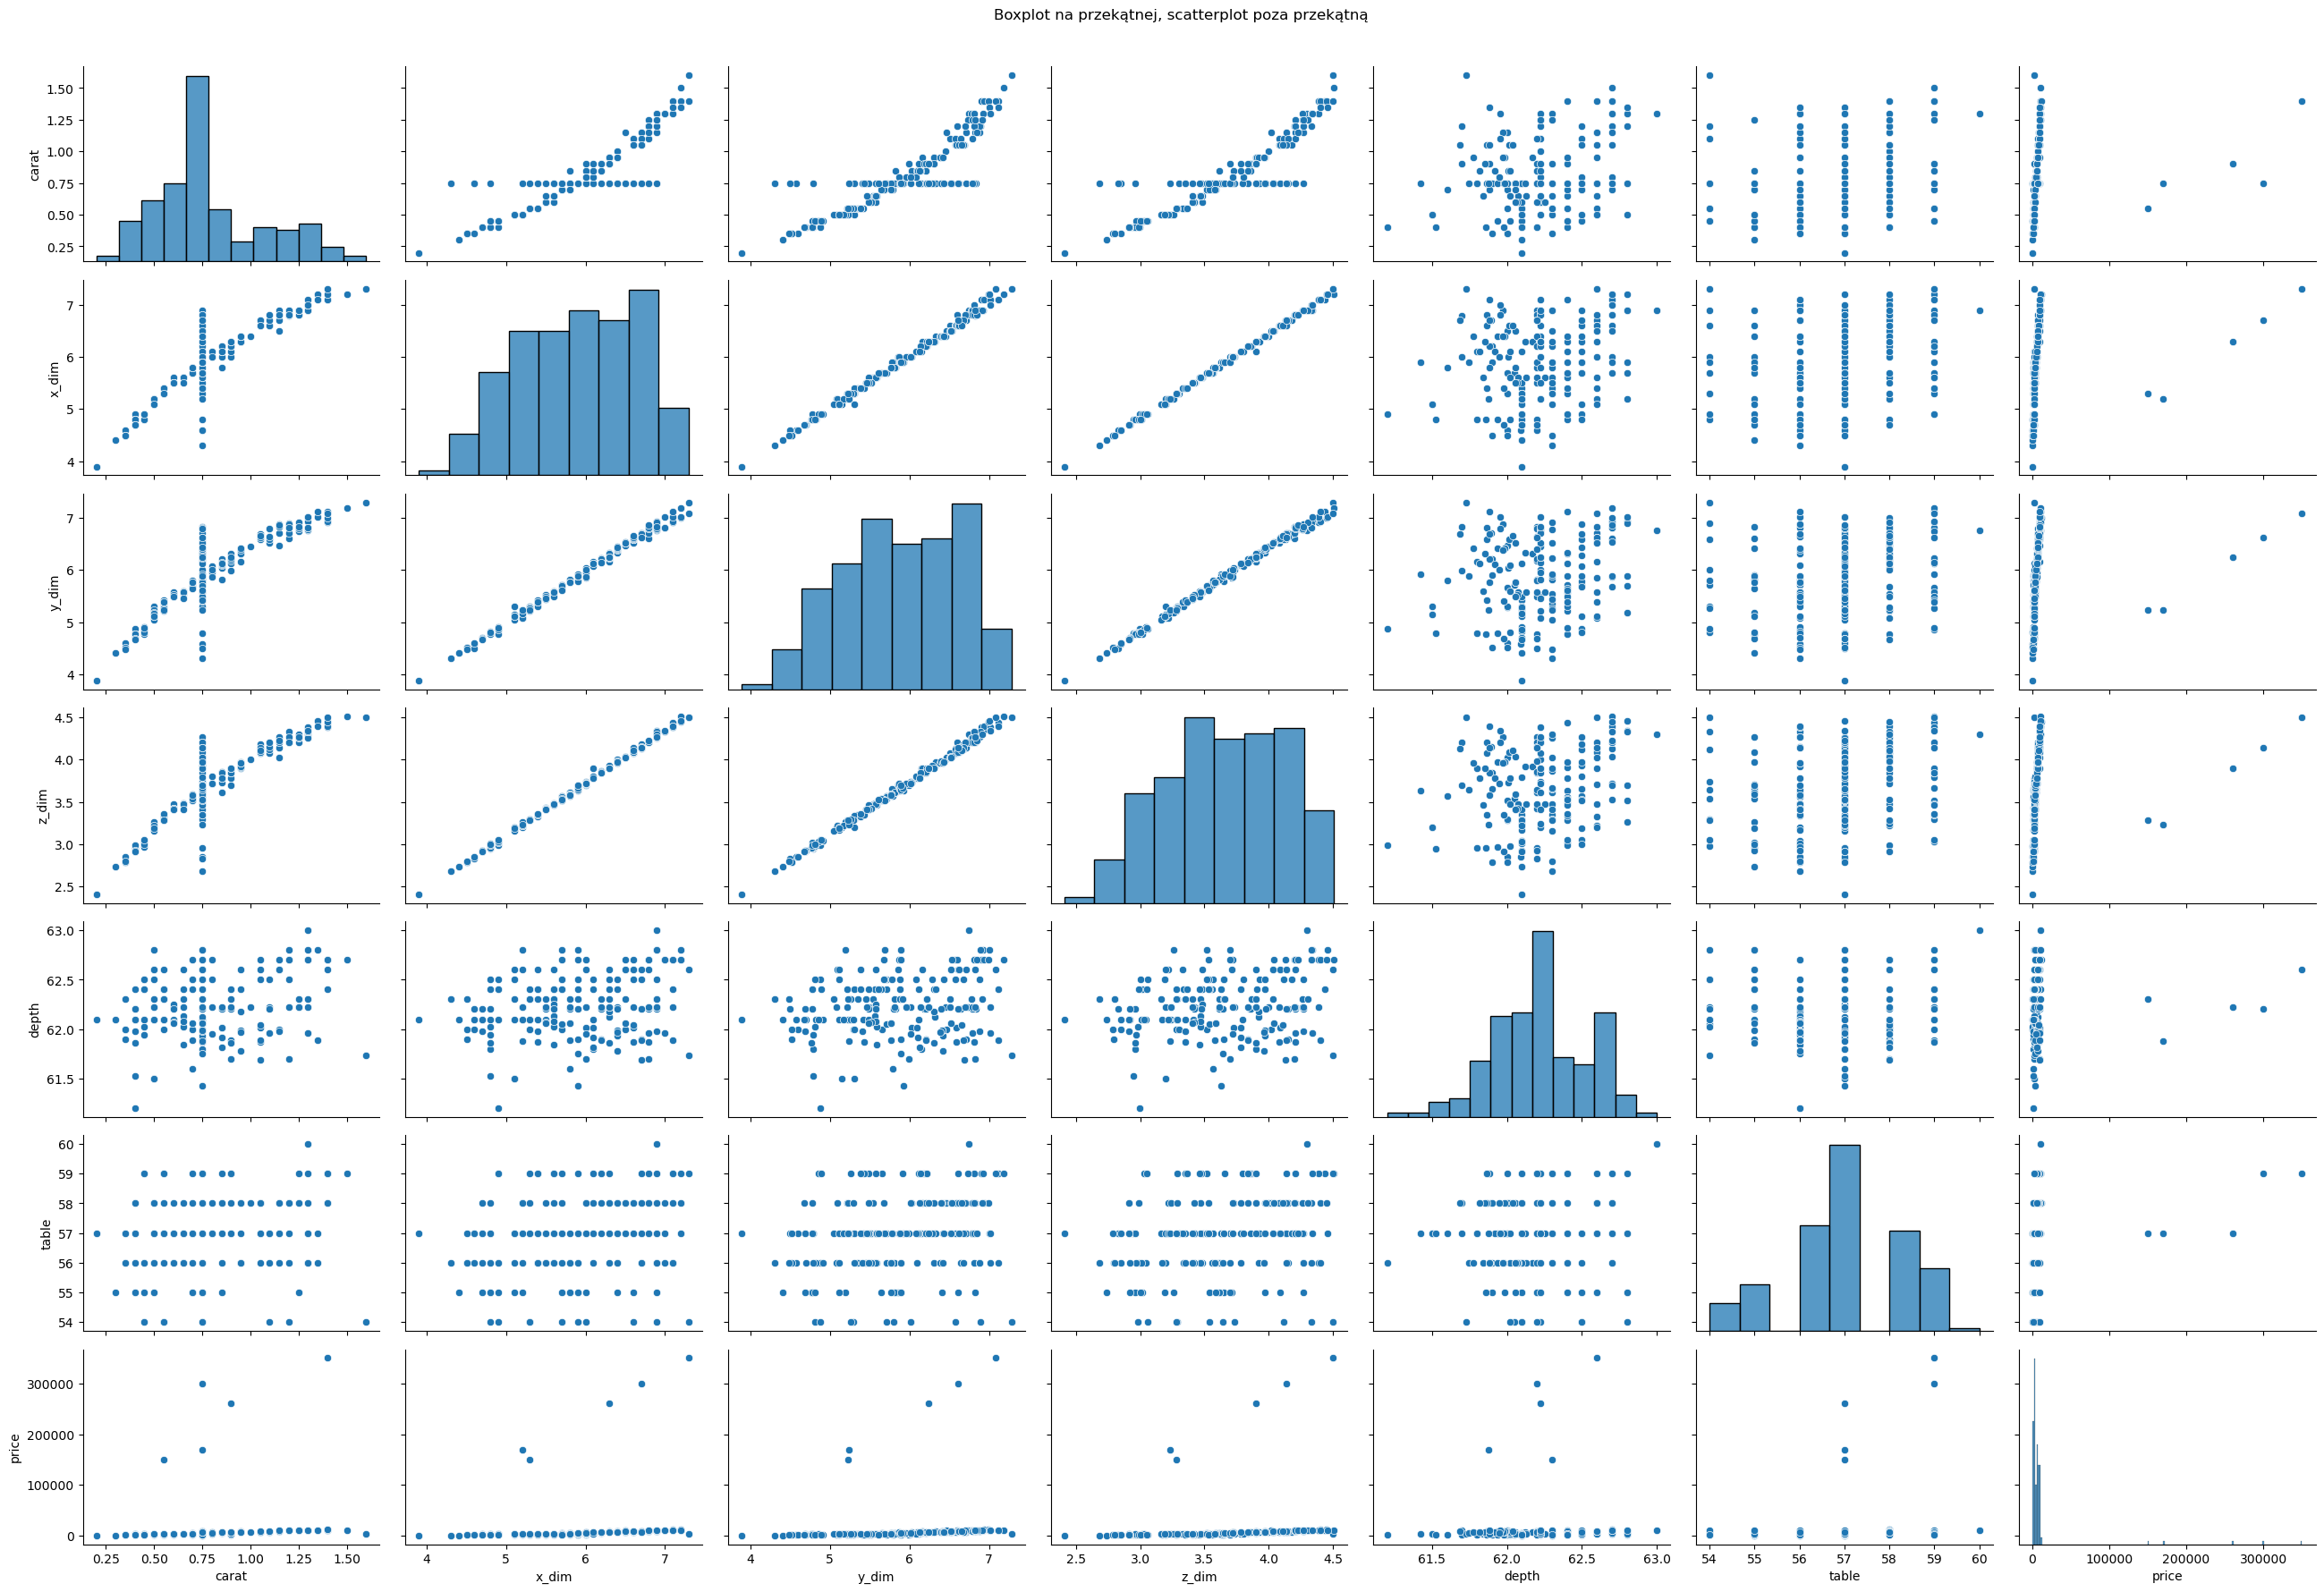

In [21]:
def plot_diagonal_histplot_scatter(df, variables):
    # Wybierz wybrane zmienne do analizy
    selected_variables = df[variables]

    # Stwórz macierz wykresów
    g = sns.PairGrid(selected_variables, aspect=1.5, diag_sharey=False)
    
    # Ustaw boxplot na przekątnej
    g.map_diag(sns.histplot)
    
    # Ustaw scatterplot poza przekątną
    g.map_offdiag(sns.scatterplot)
    
    # Dodaj tytuł
    plt.suptitle('Boxplot na przekątnej, scatterplot poza przekątną', y=1.02)
    
    # Wyświetl wykres
    plt.show()

# Przykład użycia dla wybranych zmiennych
selected_variables = ["carat","x_dim", "y_dim", "z_dim", "depth", "table", "price"]
plot_diagonal_histplot_scatter(df, selected_variables)


Widzimy, że dodanie Carat za pomocą mediany nie było idealn widać jasno, że te wartości są zależne od x,y,z więc można by było użyć prostego modelu regresji do ich predykcji, jednak narazie tą zmianę zostawiam w sekcji TODO, zakładając, że i tak te zmienne są zależne więc przy modelu regresji nie będę potrzebował obu zmiennych.  (reszta uwag niżej)

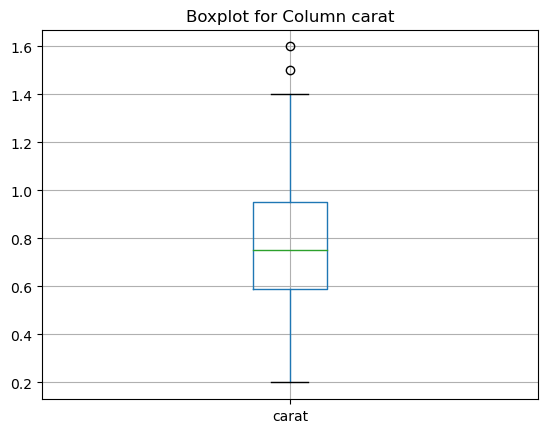

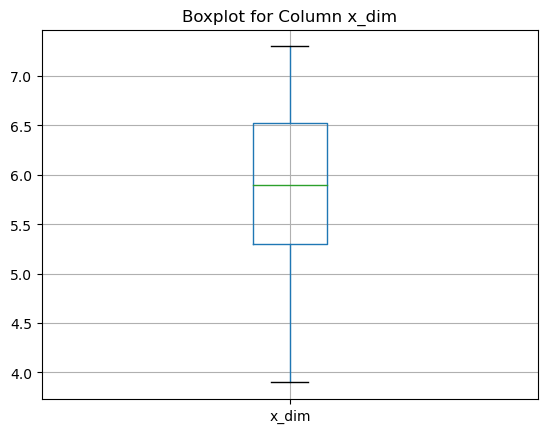

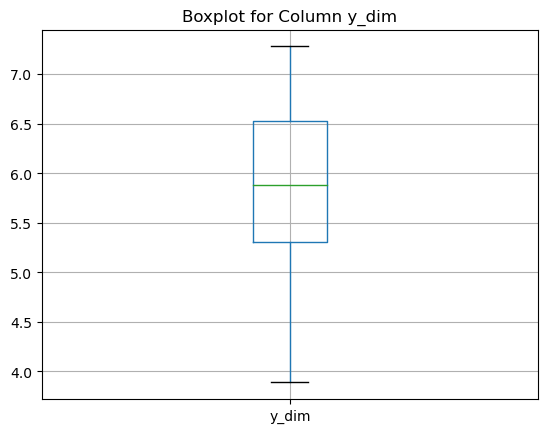

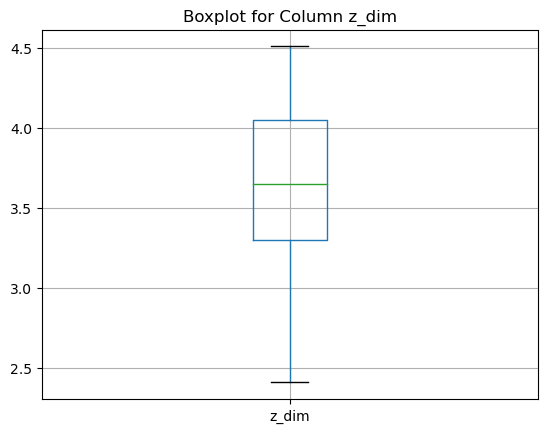

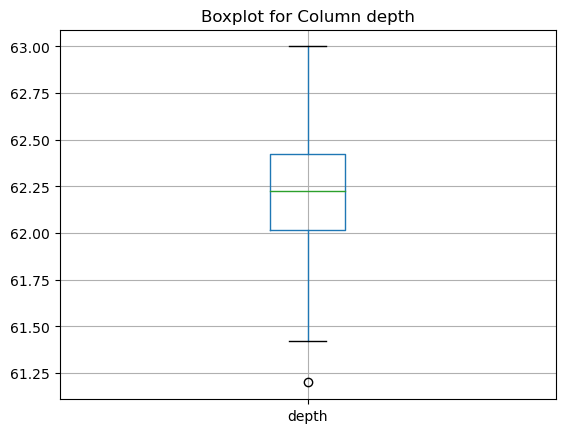

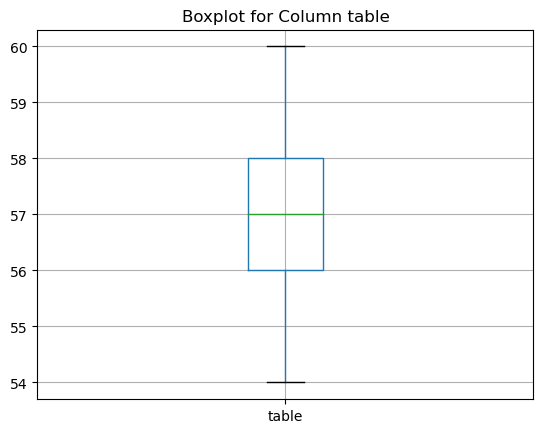

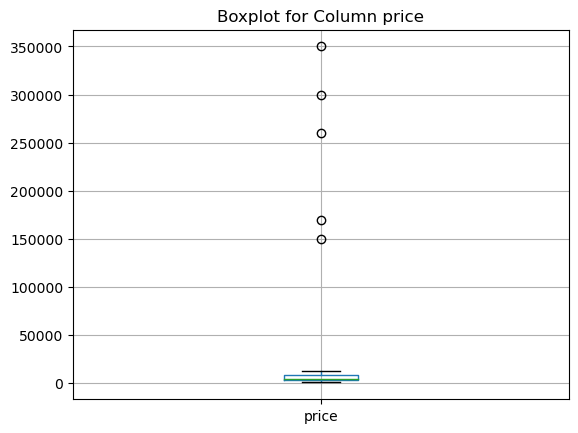

In [22]:
# Select only numeric columns
numeric_columns = df.select_dtypes(include='number')

for column in numeric_columns.columns:
    plt.figure()
    df.boxplot(column=[column])
    plt.title(f'Boxplot for Column {column}')
plt.show()

Usuńmy tą jedną wartośc odstającą w depth,wartości w carat wyglądają normalnie w innych zależnych kolumnach (po prostu są dośc duże, ale zależnośc jest zachowana), więc je zostawmy, co do price, to te wielkie wartości mogą być ważne i informacja o nich może być zawarta w którejś ze zmiennych kategorycznych, więc uważam, że nie powinny być na ten moment usunięte, jednak możliwe, że po modelowaniu zdecyduje się je usunąć i porównać wyniki. Dodatkowo, domyślam się, że rozkład ceny, jak wielu rzeczy właśnie związanych z pieniędzmi jest rozkładem wykładniczym (np. zarobki), czyli kształt histogramu jest w pewnym sensie OK.

In [23]:
IQR = df.depth.quantile(0.75) - df.depth.quantile(0.25)

lower_outliers = df[df.depth < df.depth.quantile(0.25) - 1.5*IQR]

df = df[-df['depth'].isin(lower_outliers['depth'])]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 195 entries, 0 to 199
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    195 non-null    float64
 1   clarity  195 non-null    object 
 2   color    195 non-null    object 
 3   cut      195 non-null    object 
 4   x_dim    195 non-null    float64
 5   y_dim    195 non-null    float64
 6   z_dim    195 non-null    float64
 7   depth    195 non-null    float64
 8   table    195 non-null    float64
 9   price    195 non-null    float64
dtypes: float64(7), object(3)
memory usage: 16.8+ KB


### e) Skala wartości

skalę wartości porównajmy przedstawiając wszystkie zmienne liczbowe na jednym wykresie

<Axes: >

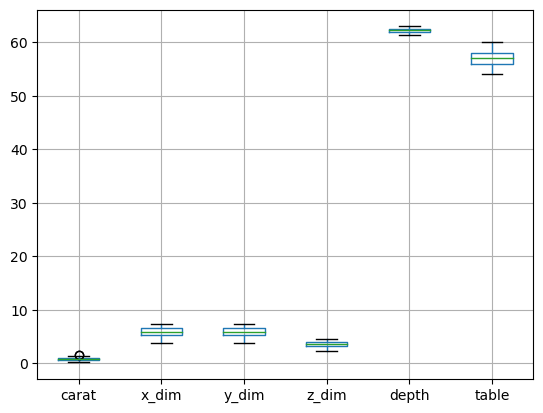

In [24]:
df.drop(['price'],axis=1).boxplot()

Widzimy, że dla modelu regresji będzie potrzebne przeskalowanie danych, zróbmy to, wybieram standaryzację, gdyż histogramy wyglądały podobnie do rozkładu normalnego :).

C:\Users\micha\AppData\Local\Temp\ipykernel_15544\115937674.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[numeric_columns_without_price] = scaler.fit_transform(df[numeric_columns_without_price])


<Axes: >

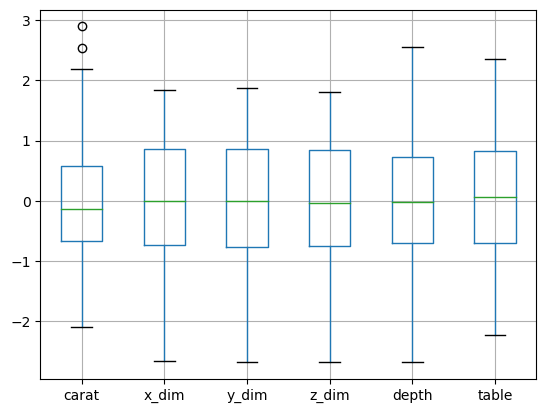

In [25]:
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
numeric_columns_without_price = [col for col in numeric_columns if col != 'price']
scaler = StandardScaler()

df[numeric_columns_without_price] = scaler.fit_transform(df[numeric_columns_without_price])
df.drop(['price'],axis=1).boxplot()

### Zadanie 2 - liczebnośc kategorii + Zadanie 1 f) Inne

Jeszcze jedną rzecz możemy zrobić w innych, mianowicie, przygotujmy dane do modelu docelowego, czyli modelu regresji:

Jednak jak to zrobimy, utrudnimy sobie wizualizację liczebności, więc zróbmy ją wcześniej.

In [26]:
#df.info()
print(df.color.unique())
print(df.clarity.unique())
print(df.cut.unique())

['D' 'E' 'H' 'J' 'G' 'F' 'I' 'COLORLESS']
['IF' 'VVS2' 'SI2' 'I1' 'SI1' 'VVS1']
['IDEAL' 'PREMIUM' 'GOOD' 'FAIR' 'VERY GOOD']


Dla "cut" mamy prostą zależność, słaby - dobry, zakodujemy ją oceną od 1 do 5, natomiast dla clarity i color spróbujmy znaleźć przedziały price, dla każdej kategorii.

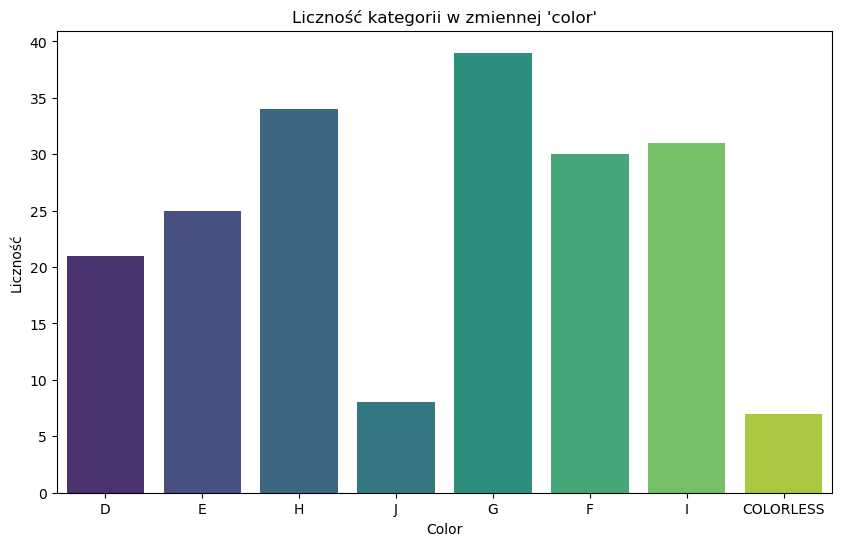

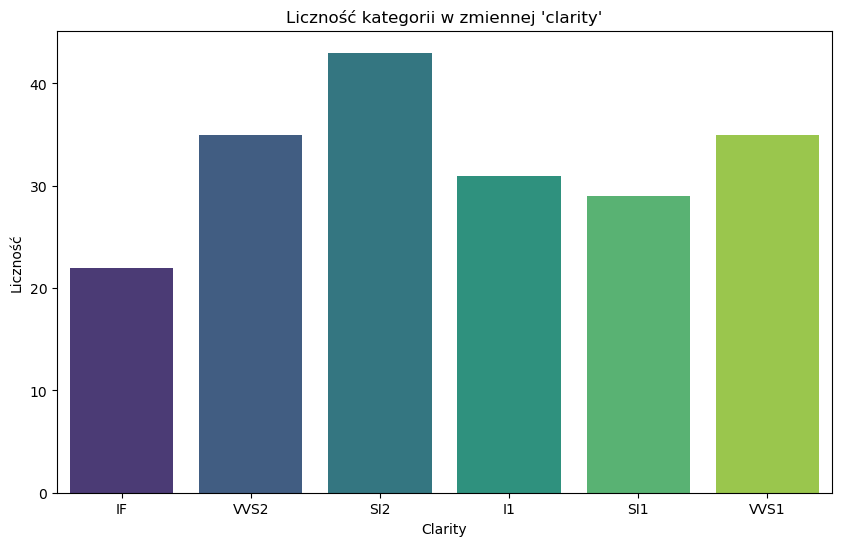

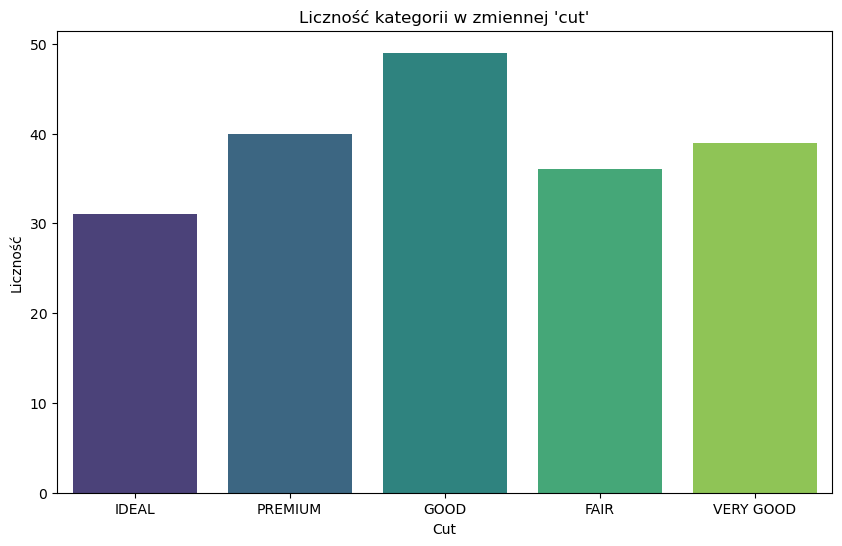

In [27]:
plt.figure(figsize=(10, 6))
sns.countplot(x='color', data=df, palette='viridis')
plt.title('Liczność kategorii w zmiennej \'color\'')
plt.xlabel('Color')
plt.ylabel('Liczność')
plt.show()

plt.figure(figsize=(10, 6))
sns.countplot(x='clarity', data=df, palette='viridis')
plt.title('Liczność kategorii w zmiennej \'clarity\'')
plt.xlabel('Clarity')
plt.ylabel('Liczność')
plt.show()

plt.figure(figsize=(10, 6))
sns.countplot(x='cut', data=df, palette='viridis')
plt.title('Liczność kategorii w zmiennej \'cut\'')
plt.xlabel('Cut')
plt.ylabel('Liczność')
plt.show()

Większośc zmiennych jest równomiernie rozłożona i nie powinno być problemu przy próbkowaniu na zbiór treningowy i testowy. Sprawdźmy zależnośc price od tych zmiennych:

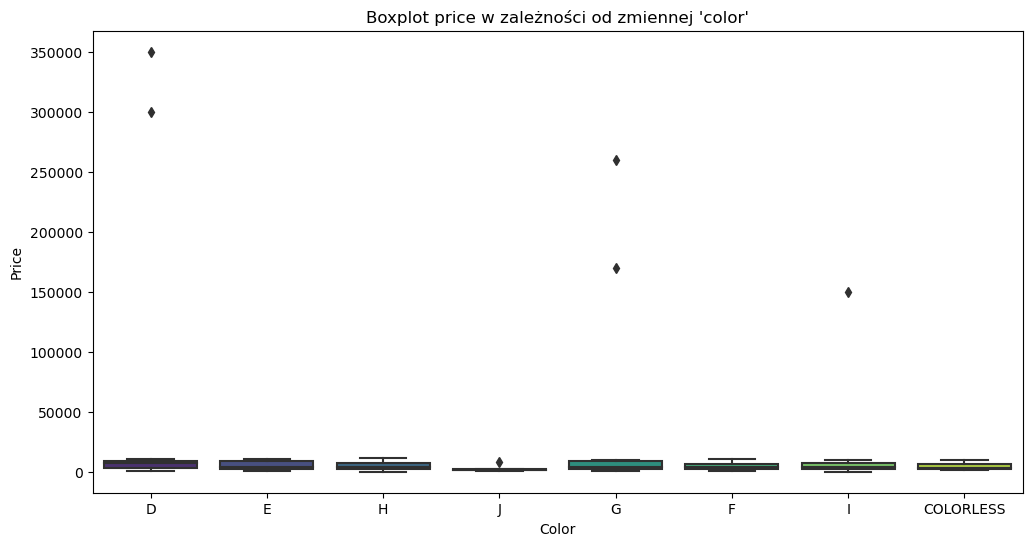

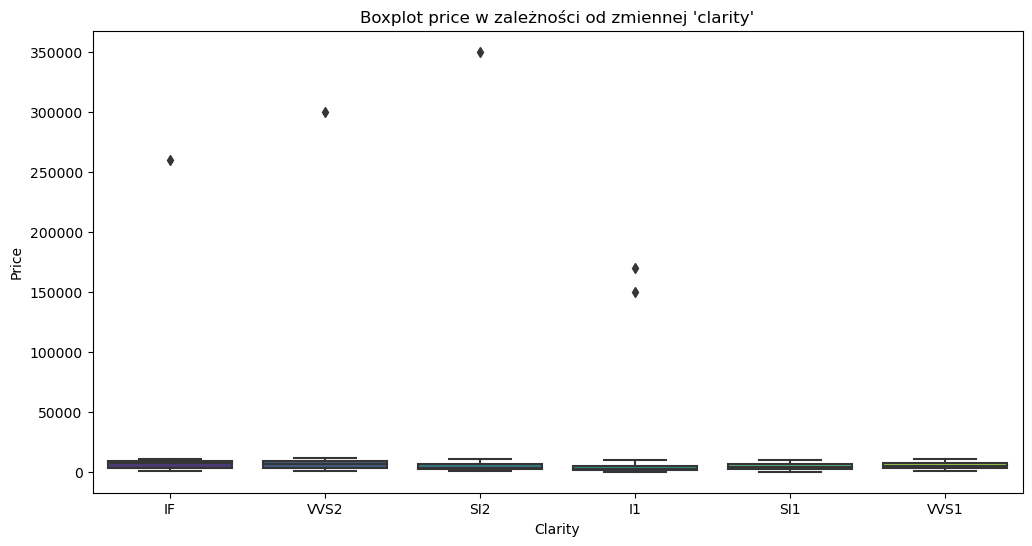

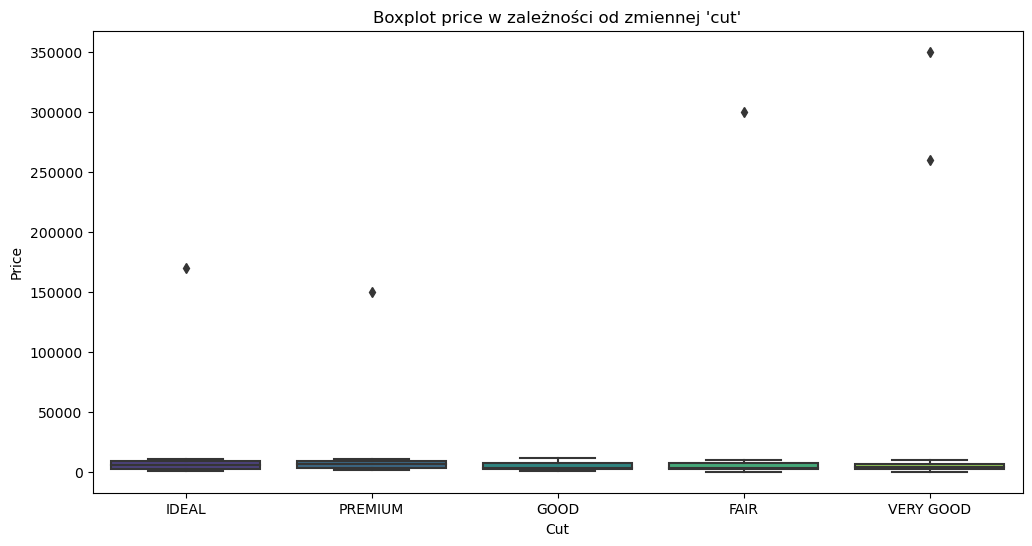

In [28]:
# Boxplot dla zmiennej 'price' w zależności od zmiennej 'color'
plt.figure(figsize=(12, 6))
sns.boxplot(x='color', y='price', data=df, palette='viridis')
plt.title('Boxplot price w zależności od zmiennej \'color\'')
plt.xlabel('Color')
plt.ylabel('Price')
plt.show()

# Boxplot dla zmiennej 'price' w zależności od zmiennej 'clarity'
plt.figure(figsize=(12, 6))
sns.boxplot(x='clarity', y='price', data=df, palette='viridis')
plt.title('Boxplot price w zależności od zmiennej \'clarity\'')
plt.xlabel('Clarity')
plt.ylabel('Price')
plt.show()

# Boxplot dla zmiennej 'price' w zależności od zmiennej 'cut'
plt.figure(figsize=(12, 6))
sns.boxplot(x='cut', y='price', data=df, palette='viridis')
plt.title('Boxplot price w zależności od zmiennej \'cut\'')
plt.xlabel('Cut')
plt.ylabel('Price')
plt.show()

Niestety te wielkie wartości występują w każdej z klas, co zdecydowanie zaburza pogląd, zróbmy wykres bez nich:

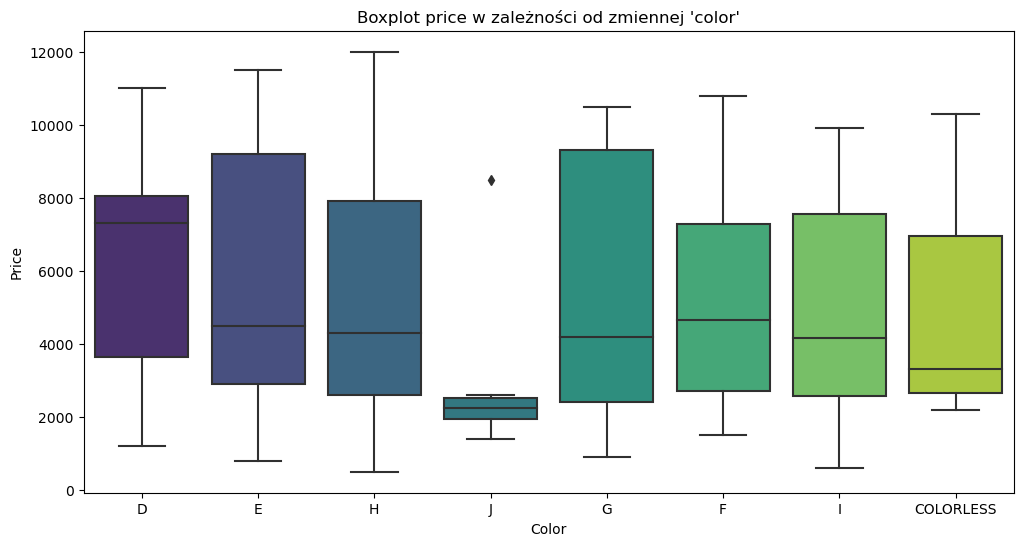

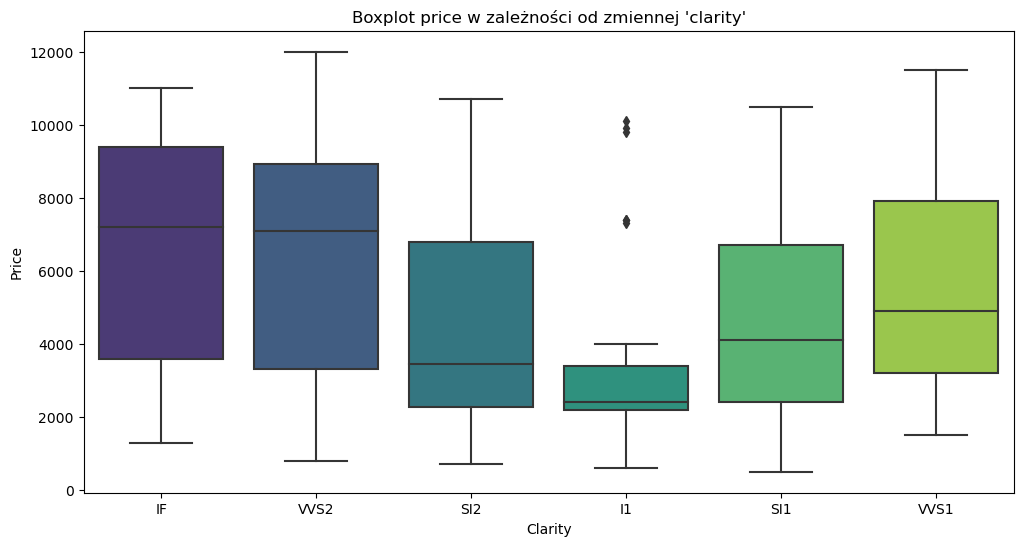

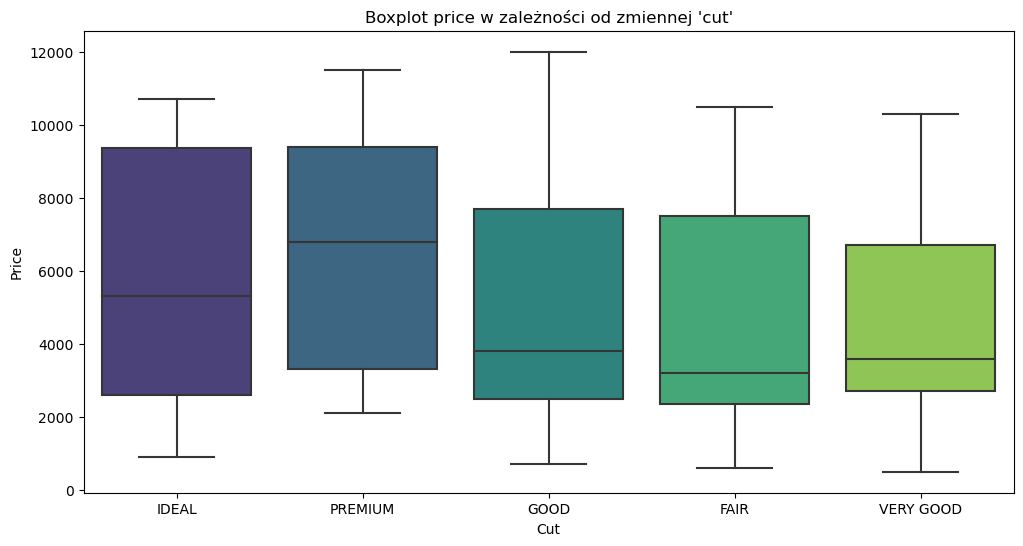

In [29]:
cut_df = df.copy()
cut_df = cut_df[cut_df['price'] < 100000]
# Boxplot dla zmiennej 'price' w zależności od zmiennej 'color'
plt.figure(figsize=(12, 6))
sns.boxplot(x='color', y='price', data=cut_df, palette='viridis')
plt.title('Boxplot price w zależności od zmiennej \'color\'')
plt.xlabel('Color')
plt.ylabel('Price')
plt.show()

# Boxplot dla zmiennej 'price' w zależności od zmiennej 'clarity'
plt.figure(figsize=(12, 6))
sns.boxplot(x='clarity', y='price', data=cut_df, palette='viridis')
plt.title('Boxplot price w zależności od zmiennej \'clarity\'')
plt.xlabel('Clarity')
plt.ylabel('Price')
plt.show()

# Boxplot dla zmiennej 'price' w zależności od zmiennej 'cut'
plt.figure(figsize=(12, 6))
sns.boxplot(x='cut', y='price', data=cut_df, palette='viridis')
plt.title('Boxplot price w zależności od zmiennej \'cut\'')
plt.xlabel('Cut')
plt.ylabel('Price')
plt.show()

Wykresy clarity mnie zainteresowały i rzeczywiście po wyszukaniu w internecie, w nich też jest pewna kolejnośc, od lepszego do gorszego, tak samo w cut, co potwierdziło moje bardzo wczesne przypuszczenia. Dla coloru, nie jestem w stanie jednoznacznie takiej zależności wykryć, więc zostanę przy one hot encoding.
Podsumowując:

5. Premium, 4. Ideal, 3. Very Good, 2. Good, 1. Fair

6. IF, 5. VVS2, 4. VVS1, 3. SI2,2. SI1,1. l1

-1 według label encodera

In [30]:
le_cut = LabelEncoder()
le_clarity = LabelEncoder()
ohe = OneHotEncoder()

kolejnosc_cut = ["FAIR", "GOOD", "VERY GOOD", "IDEAL", "PREMIUM"]
kolejnosc_clarity = ['IF','VVS2', 'VVS1', 'SI2', 'SI1', 'I1']
kolejnosc_clarity = kolejnosc_clarity[::-1] #napisałem od tyłu

encoded_cut = le_cut.fit_transform(kolejnosc_cut)
encoded_clarity = le_clarity.fit_transform(kolejnosc_clarity)

mapping_cut = dict(zip(le_cut.classes_, le_cut.transform(le_cut.classes_)))
mapping_clarity = dict(zip(le_clarity.classes_, le_clarity.transform(le_clarity.classes_)))

df['cut'] = df['cut'].map(mapping_cut)
df['clarity'] = df['clarity'].map(mapping_clarity)

#W sumie nie wiem czy nie mogłem sam sobie takiego słownika zrobić lol, ale jak już jest to niech zostanie :)

C:\Users\micha\AppData\Local\Temp\ipykernel_15544\3965269756.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cut'] = df['cut'].map(mapping_cut)
C:\Users\micha\AppData\Local\Temp\ipykernel_15544\3965269756.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['clarity'] = df['clarity'].map(mapping_clarity)


In [31]:
df_test = pd.get_dummies(df["color"],prefix='color')
df = pd.concat([df, df_test], axis=1)
df.head()

,carat,clarity,color,cut,x_dim,y_dim,z_dim,depth,table,price,color_COLORLESS,color_D,color_E,color_F,color_G,color_H,color_I,color_J
0,-1.035477,1,D,2,-1.070851,-0.989210,-0.996194,-2.427473,0.062818,3000.0,False,True,False,False,False,False,False,False
1,-0.320090,5,E,3,-0.275337,-0.309096,-0.311321,-0.767408,1.594009,4500.0,False,False,True,False,False,False,False,False
2,-0.141243,3,H,1,-2.131537,-2.120851,-2.104799,0.228632,-0.702777,700.0,False,False,False,False,False,True,False,False
3,1.468379,1,D,2,1.175498,1.260598,1.144034,-1.763447,0.828413,10000.0,False,True,False,False,False,False,False,False
4,0.395297,0,J,0,0.122420,0.147168,0.073920,-1.763447,0.062818,2400.0,False,False,False,False,False,False,False,True


## Zadanie 2 

Kawałek jest zrobiony powyżej, pozostało:
- Wizualizacja rozkładu zmiennych (już był przy szukaniu wartości odstających oraz powyżej przy liczebności kategorii, ale dla pierwszej warto to powtórzyć, druga jest już przekodowana)
- Zależność ceny od innych zmiennych - też się już przewijała we wcześniejszym myśleniu, ale możemy je dopełnić heatmapą korelacji.

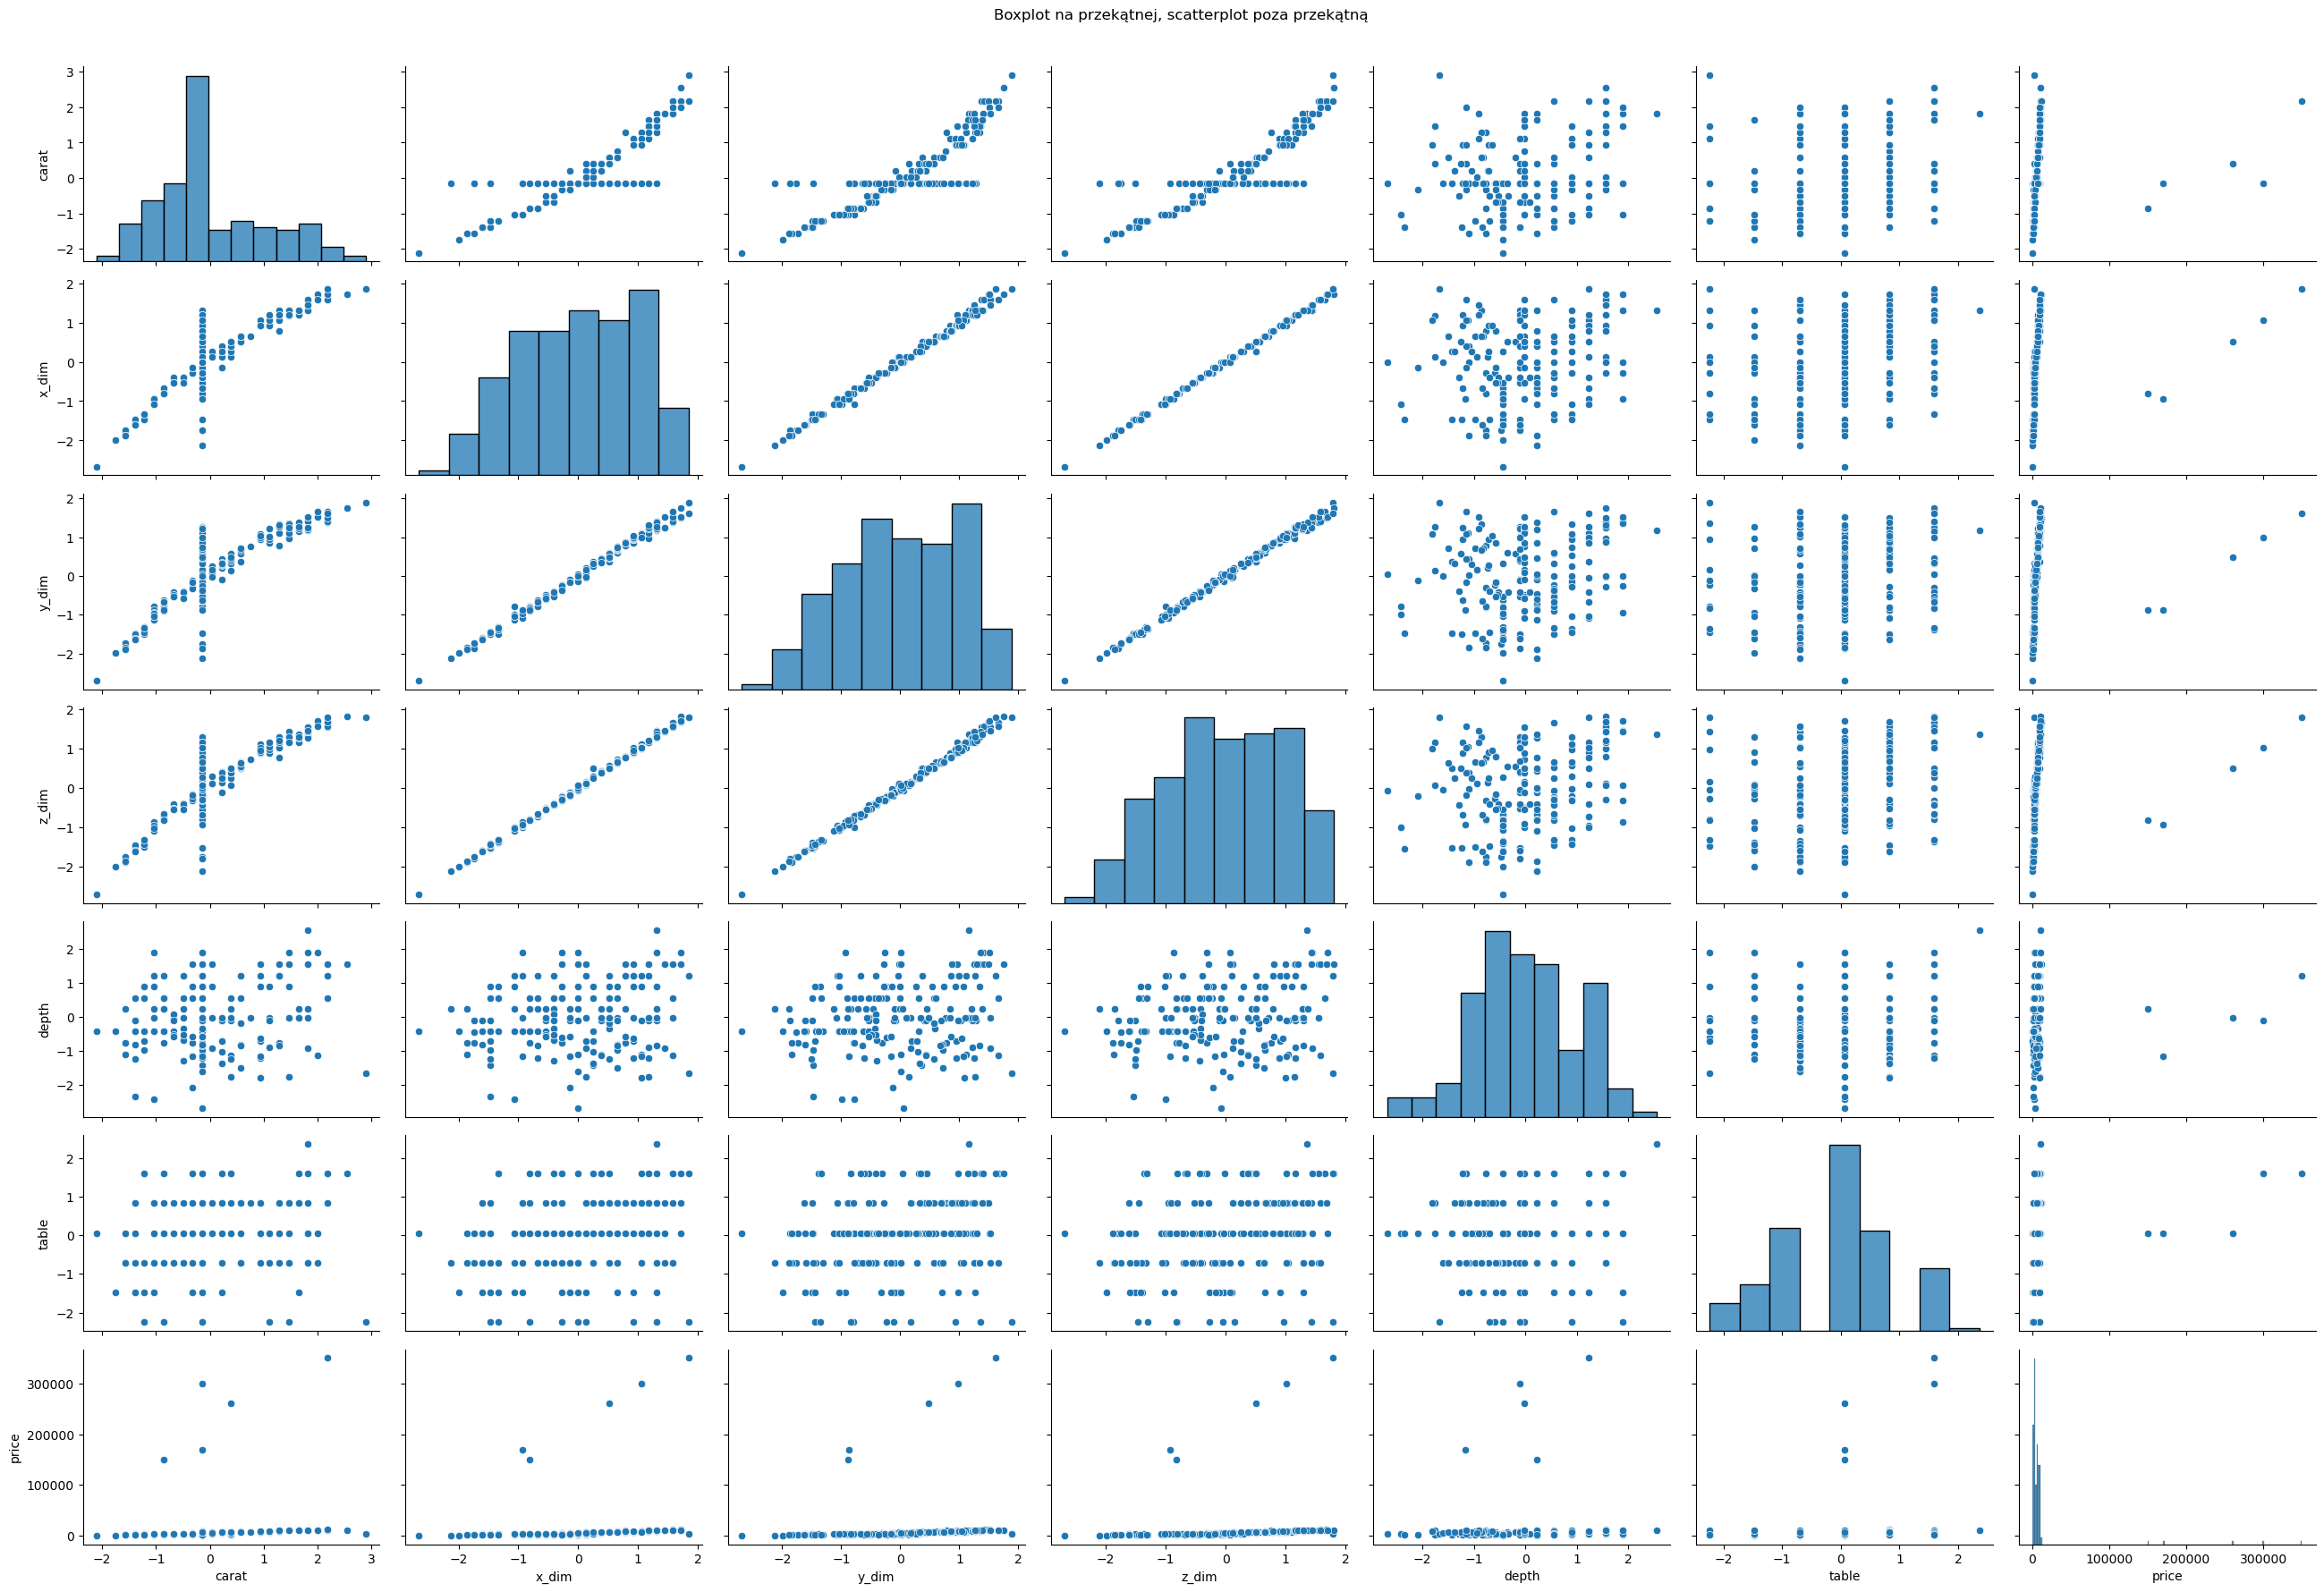

In [32]:
selected_variables = ["carat","x_dim", "y_dim", "z_dim", "depth", "table", "price"]
plot_diagonal_histplot_scatter(df, selected_variables)

Jak mówiłem wyżej, dodanie po medianie w clarity nie jest idealne, resztę wydaje mi się, że już miałem okazję omówić :)

In [33]:
correlation_matrix = df.drop("color", axis=1).corr()
print(correlation_matrix)


                    carat   clarity       cut     x_dim     y_dim     z_dim  \
carat            1.000000  0.028444 -0.013398  0.892159  0.882235  0.890536   
clarity          0.028444  1.000000 -0.122891  0.111450  0.106619  0.115125   
cut             -0.013398 -0.122891  1.000000 -0.000861 -0.002129 -0.003398   
x_dim            0.892159  0.111450 -0.000861  1.000000  0.997267  0.999230   
y_dim            0.882235  0.106619 -0.002129  0.997267  1.000000  0.997728   
z_dim            0.890536  0.115125 -0.003398  0.999230  0.997728  1.000000   
depth            0.236487  0.169191  0.012154  0.237322  0.208425  0.246762   
table            0.218823  0.135343  0.246729  0.249952  0.245575  0.248915   
price            0.148398 -0.019318  0.075509  0.171843  0.156918  0.167171   
color_COLORLESS  0.051627 -0.160743  0.158248  0.027277  0.025870  0.029018   
color_D          0.066320  0.084263 -0.078210  0.125751  0.128532  0.124876   
color_E          0.028137  0.235424  0.036761  0.042

oraz zobaczmy heatmap (powyżej tylko liczby, bo niestety program nie daje rady z taką liczbą zmiennych :())

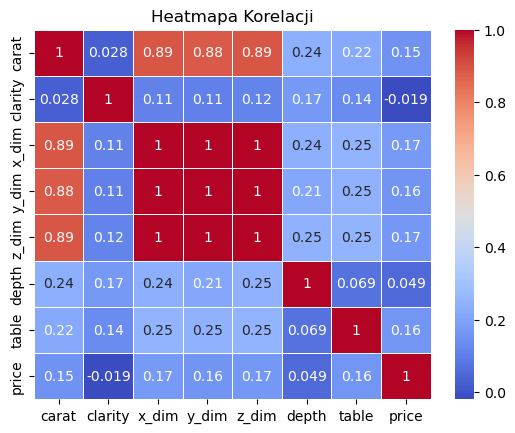

In [34]:
selected_columns = ['carat', 'clarity', 'x_dim', 'y_dim', 'z_dim', 'depth', 'table', 'price']
df_selected = df[selected_columns]

correlation_matrix = df_selected.corr()

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)

plt.title('Heatmapa Korelacji')

plt.show()

Żadna zmienna nie jest silnie skorelowana z zmienną przewidywaną price w tym wypadku, spróbujmy usunąć wartości odstające i zobaczyć różnicę dla price jak tak, tak samo modelowanie zrobię dla obu przypadków.

In [35]:
df_mini = df[df.price < 100000]
df_mini.info()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 190 entries, 0 to 199
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   carat            190 non-null    float64
 1   clarity          190 non-null    int32  
 2   color            190 non-null    object 
 3   cut              190 non-null    int32  
 4   x_dim            190 non-null    float64
 5   y_dim            190 non-null    float64
 6   z_dim            190 non-null    float64
 7   depth            190 non-null    float64
 8   table            190 non-null    float64
 9   price            190 non-null    float64
 10  color_COLORLESS  190 non-null    bool   
 11  color_D          190 non-null    bool   
 12  color_E          190 non-null    bool   
 13  color_F          190 non-null    bool   
 14  color_G          190 non-null    bool   
 15  color_H          190 non-null    bool   
 16  color_I          190 non-null    bool   
 17  color_J          190 

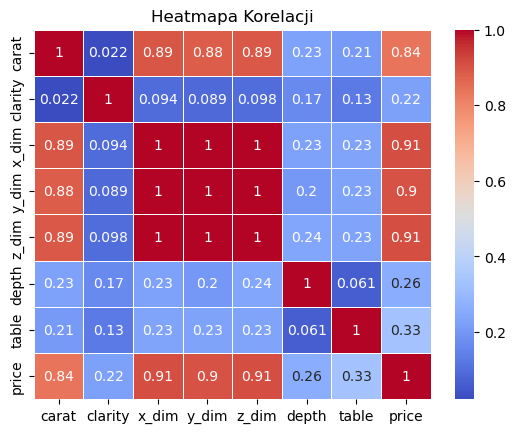

In [36]:
selected_columns = ['carat', 'clarity', 'x_dim', 'y_dim', 'z_dim', 'depth', 'table', 'price']
df_selected = df_mini[selected_columns]

correlation_matrix = df_selected.corr()

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)

plt.title('Heatmapa Korelacji')

plt.show()

Tutaj możemy powiedzieć, że price jest zależne od karatu, i wymiarów, ale one są zależne i od siebie nawzajem, ciekawy jest dla mnie natomiast brak korelacji między depth a wymiarami, mimo wyliczania z w sumie stałego zbioru. Z tego widać zależności, z którymi możemy działać.

In [37]:
correlation_matrix = df_mini.drop("color", axis=1).corr()
print(correlation_matrix)

                    carat   clarity       cut     x_dim     y_dim     z_dim  \
carat            1.000000  0.022100 -0.031191  0.894515  0.884421  0.892780   
clarity          0.022100  1.000000 -0.104813  0.094274  0.089436  0.098112   
cut             -0.031191 -0.104813  1.000000 -0.007945 -0.007281 -0.010149   
x_dim            0.894515  0.094274 -0.007945  1.000000  0.997388  0.999220   
y_dim            0.884421  0.089436 -0.007281  0.997388  1.000000  0.997772   
z_dim            0.892780  0.098112 -0.010149  0.999220  0.997772  1.000000   
depth            0.227943  0.165617  0.001833  0.227022  0.198907  0.236937   
table            0.207983  0.128539  0.253286  0.233387  0.230912  0.232960   
price            0.839403  0.221048  0.072886  0.909541  0.903967  0.910257   
color_COLORLESS  0.053910 -0.166993  0.163322  0.029472  0.027592  0.031089   
color_D          0.037094  0.057824 -0.079836  0.085777  0.093293  0.086227   
color_E          0.031569  0.235472  0.041953  0.047

Natomiast dalej żaden kolor nie wykazuje szczególnej zależności z ceną. Puśmy jeszcze raz histogramy i scatterploty, chcę zobaczyć, czy tu nie znajdę jakiegoś smaczka, np. zależności kwadratowej :)

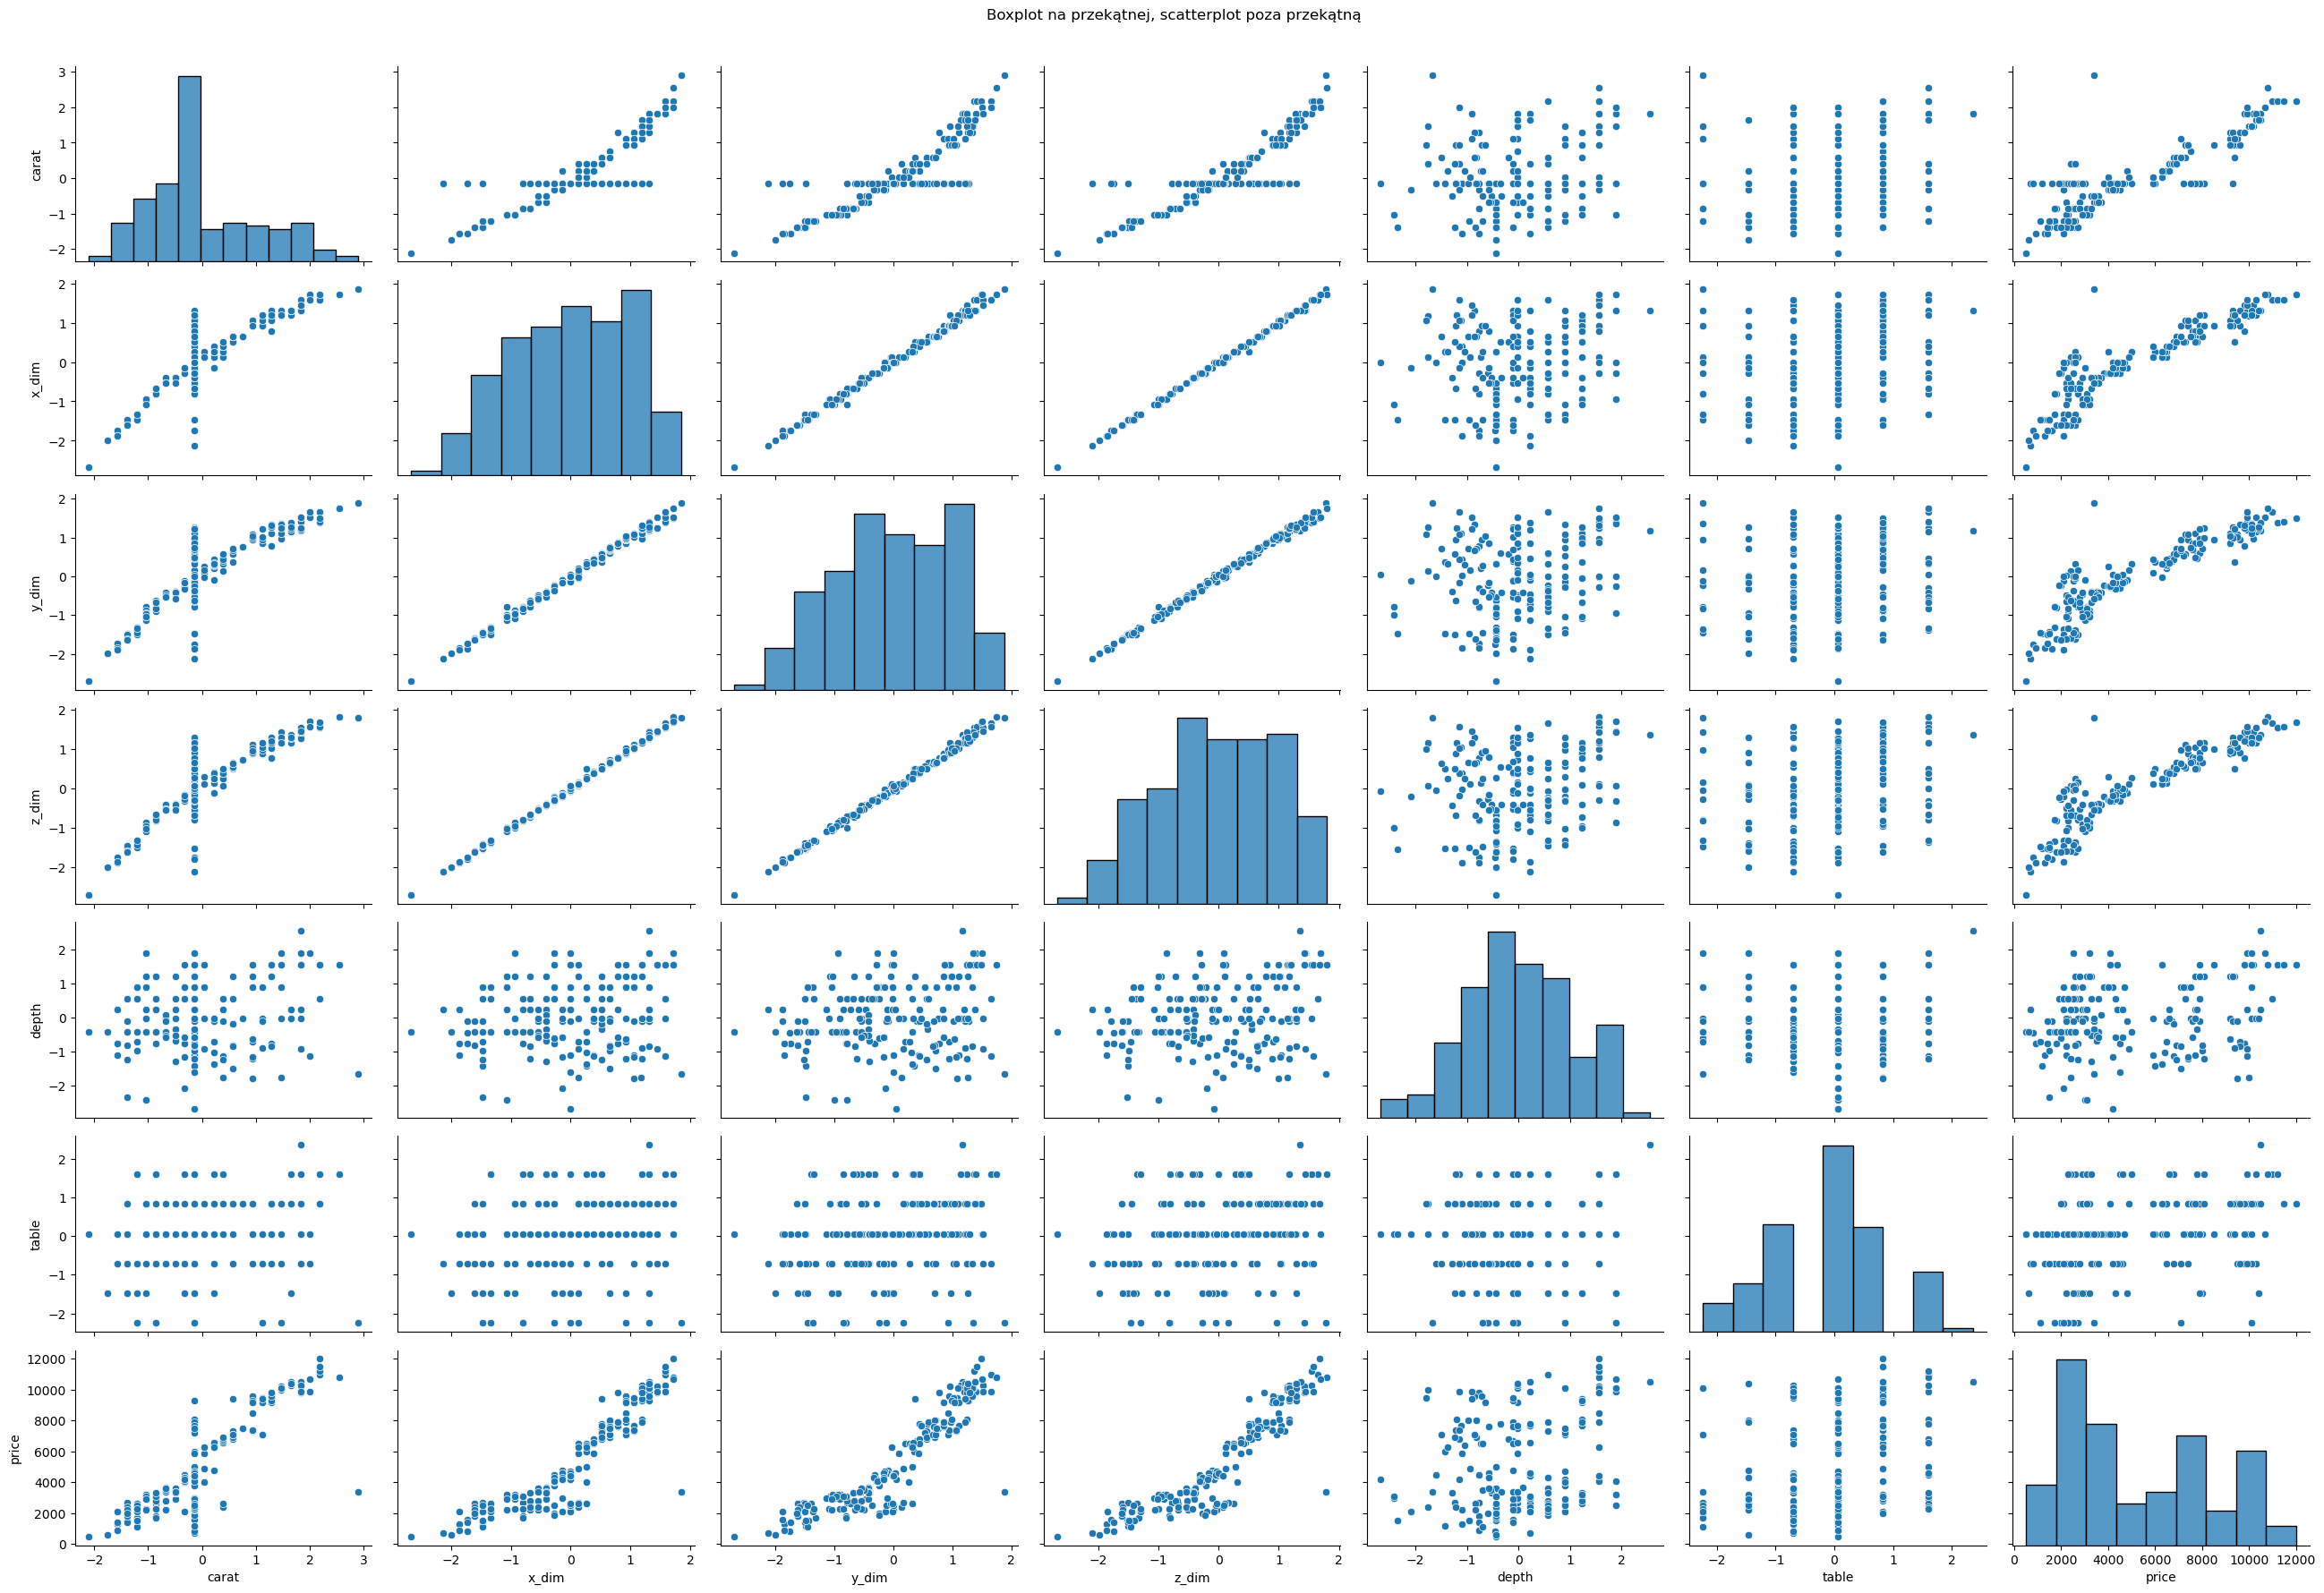

In [38]:
selected_variables = ["carat","x_dim", "y_dim", "z_dim", "depth", "table", "price"]
plot_diagonal_histplot_scatter(df_mini, selected_variables)

Widzimy, że te scatterploty nie są liniami prostymi, może taka zależnośc istnieje hmm, napewno będę o tym myślał i przy modelowaniu

## Zadanie 3 
budowa modelu regresji ceny od pozostałych zmiennych. Istotne zmienne należy wybrać eliminacją wsteczną lub selekcją postępującą.

Właściwie, to się zatrzymałem na dośc długi czas, przy próbowaniu zrozumieć, co mamy konkretnego zrobić w tym zadaniu. Chodziły mi po głowie dwie rzeczy:
- Mamy znaleźć model najlepiej dopasowany do danych, zakładając że przyszłe wartości będą miały ten sam rozkład

Kojarzy mi się to bardziej z deskrypcyjną częścią analizy
- Mamy zbadać zdolności predykcyjne różnych modeli i je porównać (niwelujemy szansę przeuczenia)

Kojarzy mi się to bardziej z predykcyjną częścią analizy
Do pierwszego lepszą biblioteką jest statsmodels natomiast do drugiego scikit.learn, ale ostatecznie pójdę w tą pierwszą stronę

Do wyboru zmiennych w regresji postępującej (z elementami wstecznej, sprawdzę dwa czynniki, krok w przód -- adjR^2, krok w tył (sprawdzenie p-value na poziomie $\alpha = 0.01$))
### Zacznijmy od zbioru z usuniętymi wartościami odstającymi

In [39]:
zmienne = df.columns.tolist()
zmienne.remove('price')
target = 'price'

empty_model = smf.ols(formula="price ~ 1", data=df_mini).fit()

print(empty_model.summary())
print(empty_model.aic)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Mon, 29 Jan 2024   Prob (F-statistic):                nan
Time:                        18:31:28   Log-Likelihood:                -1797.6
No. Observations:                 190   AIC:                             3597.
Df Residuals:                     189   BIC:                             3600.
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   5290.0000    226.102     23.397      0.0

In [40]:
adjr_list = []
for zmienna in zmienne:
    formulan = 'price ~  ' + zmienna 
    new_model = smf.ols(formula=formulan, data=df_mini).fit()
    adjr_list.append(new_model.rsquared_adj)
    
print(max(adjr_list))
print(adjr_list.index(max(adjr_list)))
print(zmienne[6])

formulan = 'price ~' + zmienne[6]
best_model = smf.ols(formula=formulan, data=df_mini).fit()
best_model.summary()

0.8276560615741408
6
z_dim


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.829
Model:                            OLS   Adj. R-squared:                  0.828
Method:                 Least Squares   F-statistic:                     908.6
Date:                Mon, 29 Jan 2024   Prob (F-statistic):           6.45e-74
Time:                        18:31:28   Log-Likelihood:                -1630.0
No. Observations:                 190   AIC:                             3264.
Df Residuals:                     188   BIC:                             3271.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   5313.0965     93.868     56.602      0.000    5127.927    5498.266
z_dim       2837.1706     94.121     30.144      0.000    2651.501    3022.840
==============================================================================
Omnibus:                       60.921   Durbin-Watson:                   2.233
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              185.704
Skew:                          -1.304   Prob(JB):                     4.73e-41
Kurtosis:                       7.081   Cond. No.                         1.01
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

$AdjR^2$ zwiększone, żadna zmienna nie ma wysokiej p--wartości, nie mamy podstaw do usunięcia jej.

In [43]:
aic_list = []
zmienne.remove('z_dim')
for zmienna in zmienne:
    formulan = 'price ~  z_dim +' + zmienna 
    new_model = smf.ols(formula=formulan, data=df_mini).fit()
    aic_list.append(new_model.rsquared_adj)
    
print(max(aic_list))
print(aic_list.index(max(aic_list)))
print(zmienne[1])

formulan = 'price ~ z_dim + ' + zmienne[1]
best_model = smf.ols(formula=formulan, data=df_mini).fit()
best_model.summary()

0.8444460853233475
1
clarity


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.846
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     514.0
Date:                Mon, 29 Jan 2024   Prob (F-statistic):           1.02e-76
Time:                        18:36:06   Log-Likelihood:                -1619.8
No. Observations:                 190   AIC:                             3246.
Df Residuals:                     187   BIC:                             3255.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   4641.1435    170.759     27.179      0.000    4304.281    4978.006
z_dim       2796.4922     89.853     31.123      0.000    2619.237    2973.748
clarity      247.7828     53.698      4.614      0.000     141.850     353.715
==============================================================================
Omnibus:                       37.442   Durbin-Watson:                   2.168
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               97.788
Skew:                          -0.826   Prob(JB):                     5.83e-22
Kurtosis:                       6.102   Cond. No.                         6.55
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

$AdjR^2$ zwiększone, żadna zmienna nie ma wysokiej p--wartości, nie mamy podstaw do usunięcia jej.

In [46]:
aic_list = []
zmienne.remove('clarity')
for zmienna in zmienne:
    formulan = 'price ~  z_dim + clarity +' + zmienna 
    new_model = smf.ols(formula=formulan, data=df_mini).fit()
    aic_list.append(new_model.rsquared_adj)
    
print(max(aic_list))
print(aic_list.index(max(aic_list)))
print(zmienne[6])

formulan = 'price ~ z_dim + clarity +  ' + zmienne[6]
best_model = smf.ols(formula=formulan, data=df_mini).fit()
best_model.summary()

0.8552684537430232
6
table


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.858
Model:                            OLS   Adj. R-squared:                  0.855
Method:                 Least Squares   F-statistic:                     373.3
Date:                Mon, 29 Jan 2024   Prob (F-statistic):           1.96e-78
Time:                        18:42:52   Log-Likelihood:                -1612.4
No. Observations:                 190   AIC:                             3233.
Df Residuals:                     186   BIC:                             3246.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   4706.3425    165.571     28.425      0.000    4379.704    5032.981
z_dim       2719.6491     88.915     30.587      0.000    2544.237    2895.061
clarity      225.7572     52.108      4.332      0.000     122.958     328.557
table        344.5737     89.019      3.871      0.000     168.957     520.190
==============================================================================
Omnibus:                       20.037   Durbin-Watson:                   2.181
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               32.826
Skew:                          -0.577   Prob(JB):                     7.45e-08
Kurtosis:                       4.677   Cond. No.                         6.60
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

$AdjR^2$ zwiększone, co prawda minimalnie, żadna zmienna nie ma wysokiej p--wartości, nie mamy podstaw do usunięcia jej.

In [49]:
aic_list = []
zmienne.remove('table')
for zmienna in zmienne:
    formulan = 'price ~  z_dim + clarity + table + ' + zmienna 
    new_model = smf.ols(formula=formulan, data=df_mini).fit()
    aic_list.append(new_model.rsquared_adj)
    
print(max(aic_list))
print(aic_list.index(max(aic_list)))
print(zmienne[0])

formulan = 'price ~ z_dim + clarity + table +' + zmienne[0]
best_model = smf.ols(formula=formulan, data=df_mini).fit()
best_model.summary()

0.8606747348131892
0
carat


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.864
Model:                            OLS   Adj. R-squared:                  0.861
Method:                 Least Squares   F-statistic:                     292.9
Date:                Mon, 29 Jan 2024   Prob (F-statistic):           7.44e-79
Time:                        18:45:11   Log-Likelihood:                -1608.3
No. Observations:                 190   AIC:                             3227.
Df Residuals:                     185   BIC:                             3243.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   4647.3928    163.746     28.382      0.000    4324.344    4970.442
z_dim       2230.9843    191.494     11.650      0.000    1853.191    2608.777
clarity      247.5322     51.687      4.789      0.000     145.560     349.504
table        340.5111     87.352      3.898      0.000     168.177     512.845
carat        543.9418    189.751      2.867      0.005     169.587     918.296
==============================================================================
Omnibus:                       40.897   Durbin-Watson:                   2.169
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              115.224
Skew:                          -0.877   Prob(JB):                     9.54e-26
Kurtosis:                       6.388   Cond. No.                         10.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

$AdjR^2$ zwiększone, co prawda minimalnie, żadna zmienna nie ma wysokiej p--wartości, nie mamy podstaw do usunięcia jej.

In [54]:
aic_list = []
zmienne.remove('carat')
for zmienna in zmienne:
    formulan = 'price ~  z_dim + clarity + table + carat +' + zmienna 
    new_model = smf.ols(formula=formulan, data=df_mini).fit()
    aic_list.append(new_model.rsquared_adj)
    
print(max(aic_list))
print(aic_list.index(max(aic_list)))
print(zmienne[1])

formulan = 'price ~ z_dim + clarity + table + carat +' + zmienne[1]
best_model = smf.ols(formula=formulan, data=df_mini).fit()
best_model.summary()

0.8657478305588835
1
cut


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.869
Model:                            OLS   Adj. R-squared:                  0.866
Method:                 Least Squares   F-statistic:                     244.8
Date:                Mon, 29 Jan 2024   Prob (F-statistic):           2.74e-79
Time:                        18:47:15   Log-Likelihood:                -1604.2
No. Observations:                 190   AIC:                             3220.
Df Residuals:                     184   BIC:                             3240.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   4244.1382    214.911     19.748      0.000    3820.132    4668.145
z_dim       2212.0779    188.094     11.760      0.000    1840.979    2583.177
clarity      268.9943     51.302      5.243      0.000     167.778     370.211
table        270.0473     89.297      3.024      0.003      93.870     446.224
carat        582.3702    186.760      3.118      0.002     213.904     950.837
cut          174.7420     61.816      2.827      0.005      52.782     296.702
==============================================================================
Omnibus:                       34.080   Durbin-Watson:                   2.119
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               95.805
Skew:                          -0.720   Prob(JB):                     1.57e-21
Kurtosis:                       6.166   Cond. No.                         12.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

$AdjR^2$ zwiększone, co prawda minimalnie, żadna zmienna nie ma wysokiej p--wartości, nie mamy podstaw do usunięcia jej.

In [57]:
aic_list = []
#zmienne.remove('cut')
for zmienna in zmienne:
    formulan = 'price ~  z_dim + clarity + table + carat + cut + ' + zmienna 
    new_model = smf.ols(formula=formulan, data=df_mini).fit()
    aic_list.append(new_model.rsquared_adj)
    
print(max(aic_list))
print(aic_list.index(max(aic_list)))
print(zmienne[0])

formulan = 'price ~ z_dim + clarity + table + carat + cut +' + zmienne[0]
best_model = smf.ols(formula=formulan, data=df_mini).fit()
best_model.summary()

0.8689478304124546
0
color


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.877
Model:                            OLS   Adj. R-squared:                  0.869
Method:                 Least Squares   F-statistic:                     105.4
Date:                Mon, 29 Jan 2024   Prob (F-statistic):           6.60e-74
Time:                        18:50:07   Log-Likelihood:                -1598.3
No. Observations:                 190   AIC:                             3223.
Df Residuals:                     177   BIC:                             3265.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3559.2144    480.966      7.400      0.000    2610.049    4508.380
color[T.D]  1091.8948    517.366      2.110      0.036      70.895    2112.895
color[T.E]   467.6788    503.863      0.928      0.355    -526.673    1462.031
color[T.F]   674.5735    487.294      1.384      0.168    -287.081    1636.228
color[T.G]   753.1346    469.866      1.603      0.111    -174.126    1680.395
color[T.H]   475.5924    492.990      0.965      0.336    -497.301    1448.486
color[T.I]   851.6360    484.103      1.759      0.080    -103.722    1806.993
color[T.J]  -115.1993    599.213     -0.192      0.848   -1297.720    1067.321
z_dim       2153.0652    188.316     11.433      0.000    1781.432    2524.699
clarity      280.8572     55.493      5.061      0.000     171.345     390.369
table        265.5743     91.284      2.909      0.004      85.430     445.719
carat        627.1689    187.087      3.352      0.001     257.961     996.377
cut          181.8156     63.524      2.862      0.005      56.453     307.178
==============================================================================
Omnibus:                       45.285   Durbin-Watson:                   2.084
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              156.734
Skew:                          -0.898   Prob(JB):                     9.24e-35
Kurtosis:                       7.071   Cond. No.                         59.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Tu już niektóre kolory przekraczają poziom istotności, czyli zostańmy przy modelu 
$$ price = \beta_0 + \beta_1 z\_dim + \beta_2 clarity + \beta_3 table + \beta_4 carat + \beta_5 cut $$
Odpadł kolor, oraz zmienne silnie zależne od z_dim

Ciekawiło mnie jeszcze czy nie ma zależności kwadratowej, sprawdźmy

In [59]:
formula= 'price ~ z_dim*z_dim'
model = smf.ols(formula=formula, data=df_mini).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.829
Model:                            OLS   Adj. R-squared:                  0.828
Method:                 Least Squares   F-statistic:                     908.6
Date:                Mon, 29 Jan 2024   Prob (F-statistic):           6.45e-74
Time:                        18:54:50   Log-Likelihood:                -1630.0
No. Observations:                 190   AIC:                             3264.
Df Residuals:                     188   BIC:                             3271.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   5313.0965     93.868     56.602      0.000    5127.927    5498.266
z_dim       2837.1706     94.121     30.144      0.000    2651.501    3022.840
==============================================================================
Omnibus:                       60.921   Durbin-Watson:                   2.233
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              185.704
Skew:                          -1.304   Prob(JB):                     4.73e-41
Kurtosis:                       7.081   Cond. No.                         1.01
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Nie widać wielkiej poprawy nad samym z

### Zbiór z wartościami odstającymi

In [60]:
zmienne = df.columns.tolist()
zmienne.remove('price')
target = 'price'

empty_model = smf.ols(formula="price ~ 1", data=df).fit()

print(empty_model.summary())
print(empty_model.aic)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Mon, 29 Jan 2024   Prob (F-statistic):                nan
Time:                        18:58:41   Log-Likelihood:                -2343.4
No. Observations:                 195   AIC:                             4689.
Df Residuals:                     194   BIC:                             4692.
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.146e+04   2876.587      3.985      0.0

In [65]:
adjr_list = []
for zmienna in zmienne:
    formulan = 'price ~  ' + zmienna 
    new_model = smf.ols(formula=formulan, data=df).fit()
    adjr_list.append(new_model.rsquared_adj)
    
print(max(adjr_list))
print(adjr_list.index(max(adjr_list)))
print(zmienne[10])

formulan = 'price ~' + zmienne[6]
best_model = smf.ols(formula=formulan, data=df).fit()
best_model.summary()

0.04329992630935675
10
color_D


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     5.549
Date:                Mon, 29 Jan 2024   Prob (F-statistic):             0.0195
Time:                        19:00:53   Log-Likelihood:                -2340.6
No. Observations:                 195   AIC:                             4685.
Df Residuals:                     193   BIC:                             4692.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.146e+04   2843.446      4.031      0.000    5853.833    1.71e+04
z_dim       6697.9074   2843.446      2.356      0.019    1089.690    1.23e+04
==============================================================================
Omnibus:                      280.314   Durbin-Watson:                   2.066
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            17357.014
Skew:                           6.597   Prob(JB):                         0.00
Kurtosis:                      47.296   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Muszę jeszcze coś zobaczyć, matematyczna pułapka, to może być eksponenta!!!!

In [69]:
#df_mini['exp_z_dim'] = np.exp(df['z_dim'])


formulan = 'price ~ np.exp(z_dim) '
model = smf.ols(formula=formulan, data=df_mini).fit()
model.summary()

model = smf.ols(formula=formulan, data=df).fit()
#model.summary()
#Dalej beznadziejnie, ale próbowałem :)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.043
Model:                            OLS   Adj. R-squared:                  0.038
Method:                 Least Squares   F-statistic:                     8.632
Date:                Mon, 29 Jan 2024   Prob (F-statistic):            0.00371
Time:                        20:49:33   Log-Likelihood:                -2339.1
No. Observations:                 195   AIC:                             4682.
Df Residuals:                     193   BIC:                             4689.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      2264.0089   4214.611      0.537      0.592   -6048.602    1.06e+04
np.exp(z_dim)  5911.4933   2012.082      2.938      0.004    1943.000    9879.987
==============================================================================
Omnibus:                      275.236   Durbin-Watson:                   2.087
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            15766.853
Skew:                           6.421   Prob(JB):                         0.00
Kurtosis:                      45.138   Cond. No.                         3.56
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Gorzej, ale chociaż spróbowałem

Już z_dim wychodzi ponad ustaloną alfę,  jakość modelu jest bardzo słaba i nie potrafi znaleźć zależności między tymi wartościami odstającymi, czyli musimy je usunąć, żeby nasz model miał jakikolwiek sens

Podsumowując:
Najlepszy model wygląda następująco i przejdziemy z nim do wizualizacji, zobaczyć w sposób graficzny jego właściwości

In [66]:
formulabest = 'price ~ z_dim + clarity + table + carat + cut'
best_model = smf.ols(formula=formulabest, data=df_mini).fit()
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.869
Model:                            OLS   Adj. R-squared:                  0.866
Method:                 Least Squares   F-statistic:                     244.8
Date:                Mon, 29 Jan 2024   Prob (F-statistic):           2.74e-79
Time:                        20:24:48   Log-Likelihood:                -1604.2
No. Observations:                 190   AIC:                             3220.
Df Residuals:                     184   BIC:                             3240.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   4244.1382    214.911     19.748      0.000    3820.132    4668.145
z_dim       2212.0779    188.094     11.760      0.000    1840.979    2583.177
clarity      268.9943     51.302      5.243      0.000     167.778     370.211
table        270.0473     89.297      3.024      0.003      93.870     446.224
carat        582.3702    186.760      3.118      0.002     213.904     950.837
cut          174.7420     61.816      2.827      0.005      52.782     296.702
==============================================================================
Omnibus:                       34.080   Durbin-Watson:                   2.119
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               95.805
Skew:                          -0.720   Prob(JB):                     1.57e-21
Kurtosis:                       6.166   Cond. No.                         12.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Zadanie 4 - Wizualizacja modelu regresji
Zobrazujmy najlepszy model jednowymiarowy (mógłbym użyć PCA do wizualizacji, ale zostańmy przy jednowymiarowym)

In [78]:
quick_model =  smf.ols(formula="price~z_dim", data=df_mini).fit()

df_mini["fitted"] = quick_model.fittedvalues

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=df_mini["z_dim"], y=df_mini["price"], name="Year vs scalled z_dim", mode="markers"))
fig.add_trace(go.Scatter(
    x=df_mini["z_dim"], y=df_mini["fitted"], name="Fitted Regression Line"))
fig.update_layout(title="Regression line of price vs standarized one of the dimensions", xaxis_title="Standarized z_dim",
    yaxis_title="Price")
fig.show()

C:\Users\micha\AppData\Local\Temp\ipykernel_15544\581100529.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [79]:
# Creating a general plotting function for plotting a scatter plot and line on the same figure
def plot_scatter_and_line(x, scatter_y, line_y, scatter_name, line_name, title, x_title, y_title):

    fig = go.Figure()
    
    fig.add_trace(go.Scatter(
        x=x, y=scatter_y, name=scatter_name, mode="markers"))
    fig.add_trace(go.Scatter(
        x=x, y=line_y, name=line_name))
    fig.update_layout(title=title, xaxis_title=x_title,
        yaxis_title=y_title)
    
    return fig

In [80]:
df_mini["residuals"] = best_model.resid
# This is just a straight line at y = 0 so we can more easily discern positive and negative residuals
line_y = [0] * len(df_mini["z_dim"])
plot_scatter_and_line(df_mini["z_dim"], df_mini["residuals"], line_y, "Model residuals", "y=0", "Model Residual Plot of Year vs Ice Extent", "Year", "Residuals")

C:\Users\micha\AppData\Local\Temp\ipykernel_15544\2271486343.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Jakbym zmienił skalowanie na [0,1] to może by lepiej działały wielomianowe i eksponenta, ale jest jak jest

In [85]:
import pylab as py
import statsmodels.api as sm 

sm.qqplot(df_mini['z_dim'], df_mini["fitted"], line ='45') 
py.show() 

AttributeError: failed to compute the ppf of fitted